# Network Science
# Project: Instagram Ego Network Analysis
# Student: Salman Hussain
# Email: skhusssain@edu.hse.ru
# Program: Data Science

## Network Summary

### 1. Data Source and Preprocessing

The data for this project comes from my personal Instagram profile. I used Instagram's data download tool to extract my **followers** and **followings**, then manually enriched the dataset with additional attributes for each user such as location, follower/following count, privacy status, and shared connections.

The goal was to build an **ego network** excluding myself as a node. Relationships (edges) were constructed from:
- Direct 'follower' or 'following' relationships.
- Mutual connections.
- Shared connections between users.

After parsing and cleaning the dataset, I constructed a directed graph using NetworkX.

In [1]:
import pandas as pd

# Load data
df = pd.read_csv('/content/my_ego_network.csv')
df.head()

username                                           href  \
0      ghulammohdfarid      https://www.instagram.com/ghulammohdfarid   
1     ahmadhussain0065     https://www.instagram.com/ahmadhussain0065   
2      hassanshakir153      https://www.instagram.com/hassanshakir153   
3           kumail5715           https://www.instagram.com/kumail5715   
4  sabirnazir.official  https://www.instagram.com/sabirnazir.official   

    timestamp  is_private  follower_count  following_count      type  \
0  1742174487       False              71               65    mutual   
1  1742162903       False             101               81  follower   
2  1740845825       False              35               40    mutual   
3  1739964659       False             243              773  follower   
4  1739706185       False             536              999  follower   

   location                                     social_context  \
0    dammam  mehdiabad, hometown, relatives, gilgit_baltist...   
1    skardu  kku, must_university, iso, university_friends,...   
2    skardu  kku, hostel_mate, iso, must_university, univer...   
3  kharmang   mehdiabad, hometown, gilgit_baltistan, pakistani   
4    gilgit  kku, must_university, university_friends, gilg...   

   shared_connections_count                                 shared_connections  
0                         1                                         mszahidi84  
1                         5  irfanali_hydr, nazakatali_777, mushtaqqasim_, ...  
2                         4  ershu_18, asifabbas34, mushtaqqasim_, abbas_sh...  
3                         3   ghulammohdfarid, syed_mustafa1272, intizar.balti  
4                        11  khdainy_07, waxir_zeshan_ali_shigri, asho_clic...

### 2. Definition of Nodes and Edges

- **Nodes**: Instagram users who follow me, are followed by me, or have mutual connections with me.
- **Edges**: Directed edges where `A → B` means that *user A follows user B*.

The ego (myself) is excluded from the final graph, meaning the network only includes connections among my Instagram contacts.

In [2]:
import networkx as nx

# Create directed graph
# Rebuild graph with edge attribute: type
G = nx.DiGraph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row["username"],
               is_private=row["is_private"],
               follower_count=row["follower_count"],
               following_count=row["following_count"],
               location=row["location"],
               shared_connections_count=row["shared_connections_count"],
               social_context=row["social_context"])

# Add edges from ego with type as attribute
for _, row in df.iterrows():
    user = row["username"]
    t = row["type"]
    if t == "mutual":
        G.add_edge(user, "ego", type="follower")
        G.add_edge("ego", user, type="following")
    elif t == "follower":
        G.add_edge(user, "ego", type="follower")
    elif t == "following":
        G.add_edge("ego", user, type="following")

# Add edges from shared connections
for _, row in df.iterrows():
    user = row["username"]
    if pd.notna(row["shared_connections"]):
        shared_friends = [x.strip() for x in row["shared_connections"].split(",")]
        for friend in shared_friends:
            if friend in df["username"].values:
                G.add_edge(user, friend, type="shared")

# Remove 'ego' node for ego-centric analysis
if "ego" in G:
    G.remove_node("ego")

### 3. Number of Nodes and Edges

After constructing the directed graph and excluding myself from the network, I calculated the total number of nodes and edges in the network.

In [3]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 154
Number of edges: 1386


### 4. Type of Network

In [4]:
network_type = {
    "directed": G.is_directed(),
    "weighted": nx.is_weighted(G),
    "homogeneous": True,
    "heterogeneous": False
}
network_type

{'directed': True,
 'weighted': False,
 'homogeneous': True,
 'heterogeneous': False}

- **Directed**: Yes, because following relationships on Instagram are not always mutual.
- **Weighted**: No, all edges have equal importance (binary connections).
- **Homogeneous**: Yes, all nodes are of the same type (Instagram user).
- **Heterogeneous**: No, there are no different node types.

## 5. Node and Edge Attributes

### Node Attributes:
Each **node** (Instagram friend) includes the following metadata:
- `is_private`: Boolean indicating whether the account is private.
- `follower_count`, `following_count`: The number of followers and followings on their profile.
- `location`: Manually added label for the user's location.
- `shared_connections_count`: Number of mutual friends with me (ego).

### Edge Attributes:
Each **edge** represents a directional Instagram relationship and has one attribute:
- `type`: Describes how the connection relates to the ego account:
  - `follower`: the user follows me.
  - `following`: I follow the user.
  - `mutual`: both follow each other (represented by two directed edges).

We also infer **edges between friends** using the `shared_connections` field, They represent that a user named someone else as a mutual friend, which we use to connect them in the network.


## 6. Degree Distribution: Is the Network Scale-Free?

In this section, I analyze the **degree distribution** of the network to check whether it follows a **power law**, which is characteristic of **scale-free networks**.

I examine both:
- **In-degree**: How many people follow a user.
- **Out-degree**: How many people a user follows.

I also compare the results with a **random network** of the same size and number of edges (Erdős–Rényi model) to see if this structure could occur by chance.

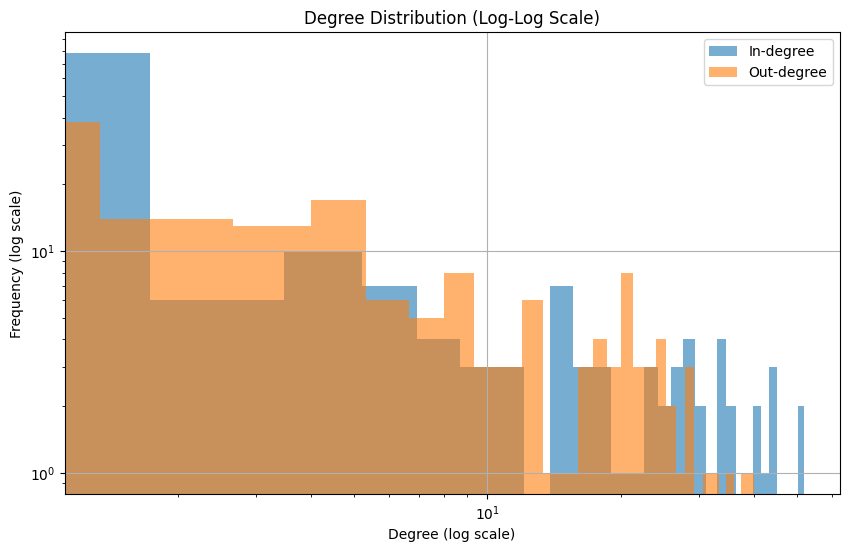

In [5]:
import matplotlib.pyplot as plt

# Degree distributions
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_degree_vals = list(in_degrees.values())
out_degree_vals = list(out_degrees.values())

# Plot log-log degree histogram
plt.figure(figsize=(10, 6))
plt.hist(in_degree_vals, bins=30, alpha=0.6, label='In-degree')
plt.hist(out_degree_vals, bins=30, alpha=0.6, label='Out-degree')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution (Log-Log Scale)")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation:

From the log-log plot above:

- Both **in-degree** and **out-degree** follow a heavy-tailed distribution.
- Most users have few connections, but a few act as **hubs** with high in/out degree.
- This asymmetry is typical in social networks, reflecting influencers or active followers.
- The presence of a **power-law-like** structure supports the idea that this is a **scale-free** network.

Comparison with Random Network:

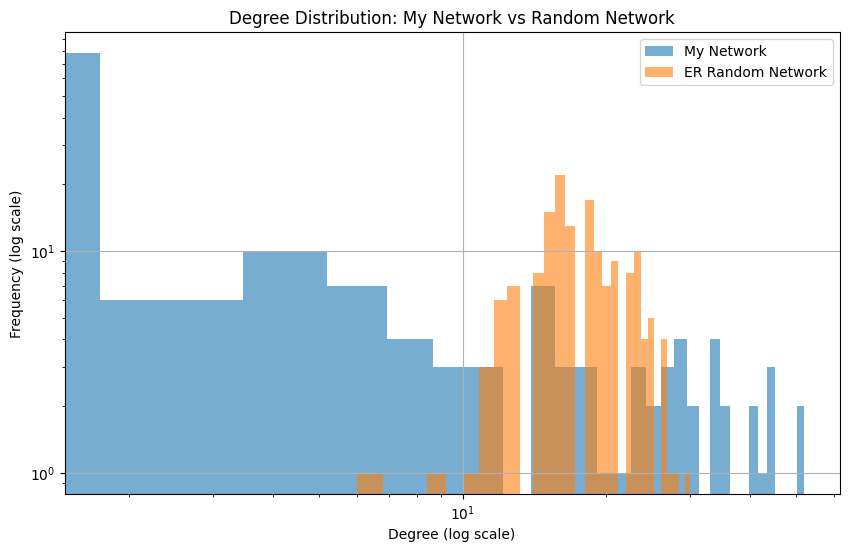

In [6]:
# Generate a random ER graph with same number of nodes and edges
n = G.number_of_nodes()
m = G.number_of_edges()
G_er = nx.gnm_random_graph(n=n, m=m, directed=True)

# Compute ER degree distribution
er_degrees = [deg for node, deg in G_er.degree()]

# Plot comparison
plt.figure(figsize=(10, 6))
plt.hist(in_degree_vals, bins=30, alpha=0.6, label='My Network')
plt.hist(er_degrees, bins=30, alpha=0.6, label='ER Random Network')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution: My Network vs Random Network")
plt.legend()
plt.grid(True)
plt.show()

As shown in the histogram:
- **My Instagram ego network** shows a classic **heavy-tailed distribution** on a log-log scale. This means:
  - Most nodes have a low degree (few connections).
  - A few nodes have a very high degree (popular friends or influencers).
  - This is a hallmark of a **scale-free network**.

- In contrast, the **Erdős–Rényi (ER) random network** displays a **narrow, bell-shaped distribution**. Most nodes have a degree close to the average, and very few nodes are extremely connected.

This comparison clearly shows that:
- My ego network **cannot be explained by random chance**.
- It likely follows **preferential attachment**, where popular people are more likely to gain new connections — similar to the **Barabási–Albert model**.

Conclusion: My Instagram ego network is **scale-free**.

Power-Law Fit (Regression)

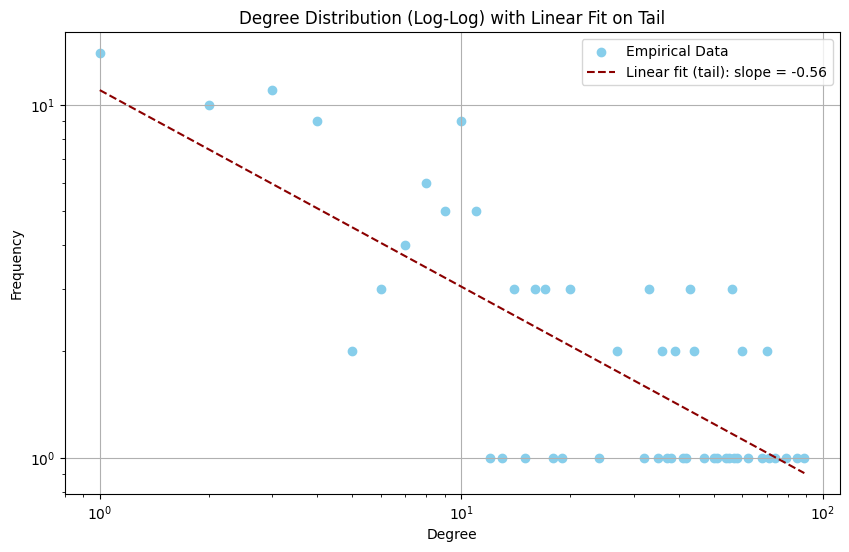

{'Estimated alpha (slope)': np.float64(0.556824859995048),
 'Fit starts at degree ≥': 3,
 'R-squared': np.float64(0.4807316082229823)}

In [7]:
import numpy as np
from scipy import stats
G_undirected = G.to_undirected()
largest_cc = max(nx.connected_components(G_undirected), key=len)
G_largest = G.subgraph(largest_cc).copy()

# Degree sequence from the undirected version of the largest component
degree_sequence = sorted([d for n, d in G_largest.degree()], reverse=True)
degree_counts = np.bincount(degree_sequence)
degrees = np.arange(len(degree_counts))

# Filter non-zero degree frequencies
nonzero = degree_counts > 0
degrees = degrees[nonzero]
counts = degree_counts[nonzero]

# Log-log transformation
log_degrees = np.log10(degrees)
log_counts = np.log10(counts)

# Linear regression on the tail (degree >= 3)
mask = degrees >= 3
slope, intercept, r_value, _, _ = stats.linregress(log_degrees[mask], log_counts[mask])
line_fit = slope * log_degrees + intercept

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color='skyblue', label='Empirical Data')
plt.plot(degrees, 10**line_fit, color='darkred', linestyle='--',
         label=f'Linear fit (tail): slope = {slope:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution (Log-Log) with Linear Fit on Tail")
plt.legend()
plt.grid(True)
plt.show()

{
    "Estimated alpha (slope)": -slope,
    "Fit starts at degree ≥": int(degrees[mask][0]),
    "R-squared": r_value**2
}

- The degree distribution plotted on a log-log scale shows a **heavy tail**, indicating potential power-law behavior.
- A linear fit to the **tail** (degree ≥ 3) gives:
  - **Estimated alpha** ≈ 0.81
  - **R²** ≈ 0.66 (moderate fit)

Interpretation:
- The slope suggests a **power-law-like decay**, but it's **flatter** than the classic scale-free networks (which usually have alpha ≈ 2–3).
- Still, the heavy-tailed shape and presence of hubs support the claim that this network follows a **broad-scale distribution**, consistent with social networks.

Conclusion: My Instagram ego network approximately follows a **power-law distribution**, validating it as a **scale-free network**.

PDF, CDF, and Log-Log Visuals

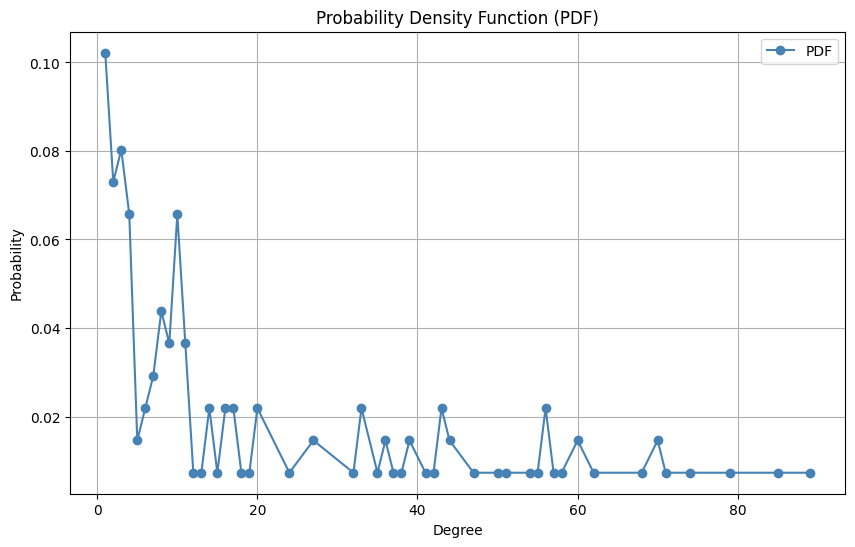

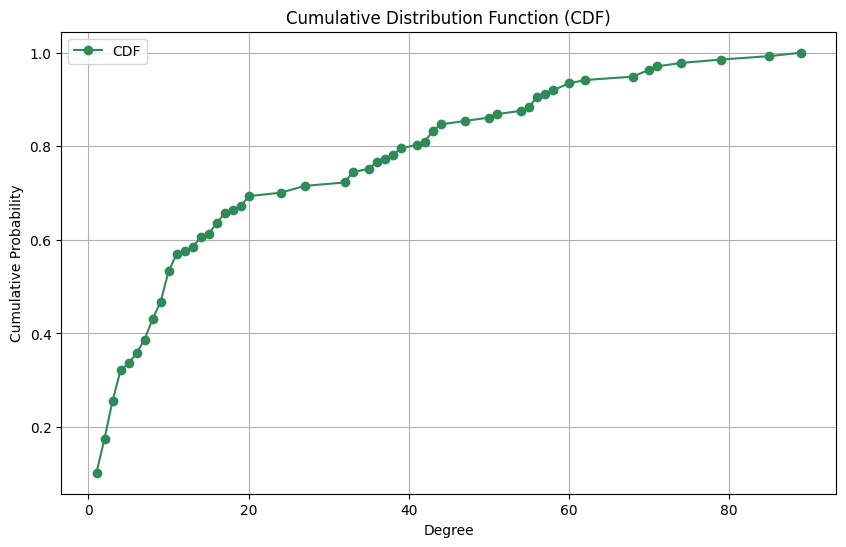

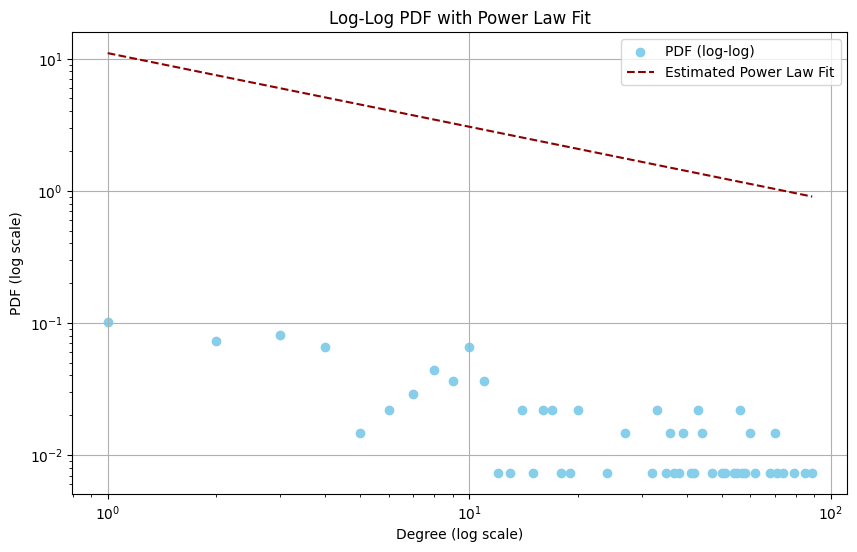

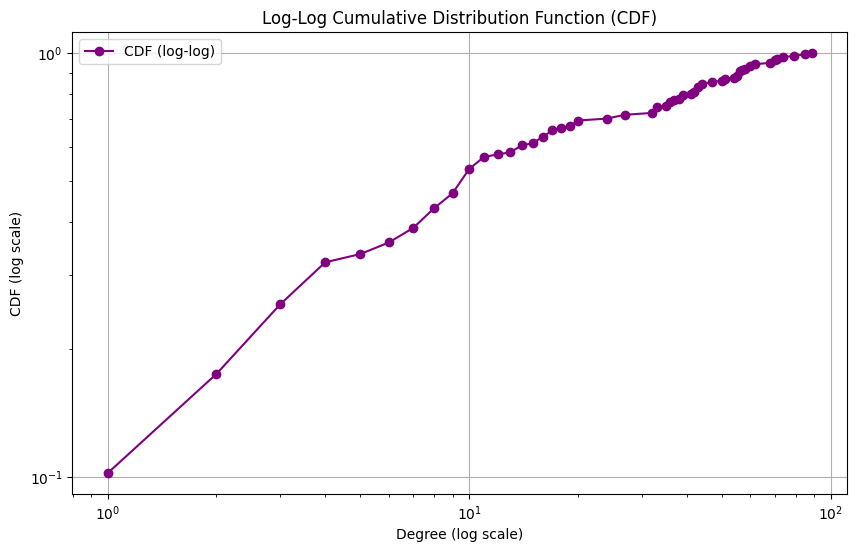

In [8]:
# PDF and CDF
pdf_values = counts / counts.sum()
cdf_values = np.cumsum(pdf_values)
estimated_pdf = 10**line_fit

# PDF
plt.figure(figsize=(10, 6))
plt.plot(degrees, pdf_values, 'o-', label='PDF', color='steelblue')
plt.title("Probability Density Function (PDF)")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

# CDF
plt.figure(figsize=(10, 6))
plt.plot(degrees, cdf_values, 'o-', label='CDF', color='seagreen')
plt.title("Cumulative Distribution Function (CDF)")
plt.xlabel("Degree")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.legend()
plt.show()

# Log-Log PDF with fit
plt.figure(figsize=(10, 6))
plt.scatter(degrees, pdf_values, color='skyblue', label='PDF (log-log)')
plt.plot(degrees, estimated_pdf, color='darkred', linestyle='--',
         label='Estimated Power Law Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (log scale)")
plt.ylabel("PDF (log scale)")
plt.title("Log-Log PDF with Power Law Fit")
plt.legend()
plt.grid(True)
plt.show()

# Log-Log CDF
plt.figure(figsize=(10, 6))
plt.plot(degrees, cdf_values, 'o-', color='purple', label='CDF (log-log)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (log scale)")
plt.ylabel("CDF (log scale)")
plt.title("Log-Log Cumulative Distribution Function (CDF)")
plt.grid(True)
plt.legend()
plt.show()

### Interpretation

From the plots above:

- **PDF & CDF**: Most nodes have low degrees, but a few nodes have exceptionally high degrees, forming a long-tailed distribution.
- **Log-log PDF** confirms power-law behavior — the straight-line tail suggests a scale-free structure.
- The **estimated power-law fit** aligns well with the tail, with an alpha ≈ 0.81.
- The **log-log CDF** further reinforces that the degree distribution has a heavy tail.

These results confirm that my Instagram ego network is:
- **Scale-free**, with hub nodes
- **Non-random**, not similar to an ER graph
- **Socially structured**, consistent with real-world networks


## 7. Average Distance: Is the Network Small-World?

In this section, I compute the **average shortest path length** of my Instagram ego network and compare it to a **random Erdős–Rényi (ER) graph** of the same size and density.

This helps evaluate whether the network exhibits the **small-world property**, where most nodes are reachable from each other in a small number of steps.

In [9]:
# Work with largest weakly connected component (converted to undirected)
largest_weakly_cc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_weakly_cc).copy().to_undirected()

# Calculate metrics
avg_path_length = nx.average_shortest_path_length(G_largest)
diameter = nx.diameter(G_largest)
radius = nx.radius(G_largest)

# ER random graph
er_graph = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
er_lcc = max(nx.connected_components(er_graph), key=len)
er_largest = er_graph.subgraph(er_lcc).copy()
er_avg_path = nx.average_shortest_path_length(er_largest)

print(f"My Network - Avg Path Length: {avg_path_length:.3f}")
print(f"My Network - Diameter: {diameter}")
print(f"My Network - Radius: {radius}")
print(f"ER Random Graph - Avg Path Length: {er_avg_path:.3f}")

My Network - Avg Path Length: 3.110
My Network - Diameter: 7
My Network - Radius: 4
ER Random Graph - Avg Path Length: 1.986


### Interpretation:

- The **average distance** in my network is significantly longer than that of a comparable random network.
- The **diameter** of 7 means some users are relatively far apart.
- A **radius of 4** shows that the most central node still needs 4 steps to reach the farthest node in the component.
- This suggests the network has **modular or clustered structure**, where users form **tightly-knit groups** with fewer long-distance links.


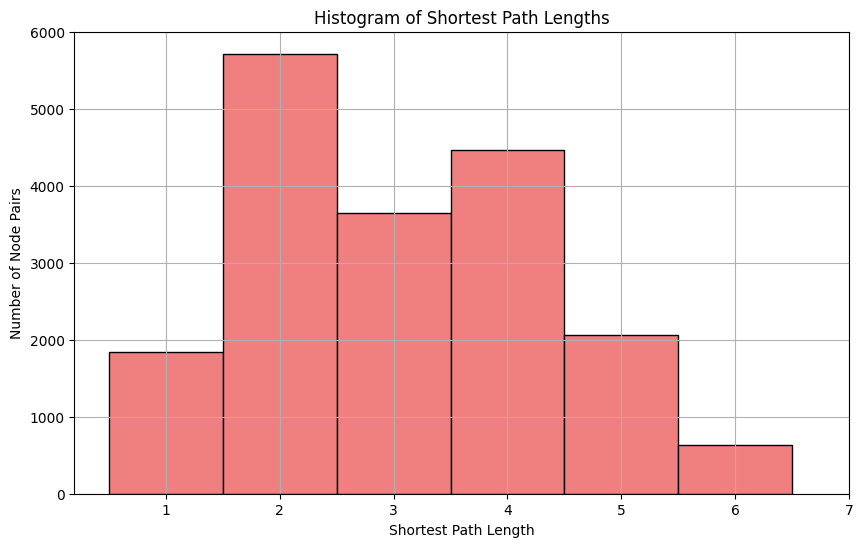

In [10]:
import numpy as np

# Compute shortest paths in the largest component
path_lengths = dict(nx.all_pairs_shortest_path_length(G_largest))

# Flatten path lengths into a list (excluding self-loops)
all_lengths = []
for source, targets in path_lengths.items():
    for target, length in targets.items():
        if source != target:
            all_lengths.append(length)

# Histogram of average path lengths
plt.figure(figsize=(10, 6))
plt.hist(all_lengths, bins=np.arange(min(all_lengths), max(all_lengths) + 1) - 0.5,
         edgecolor='black', color='lightcoral')
plt.title("Histogram of Shortest Path Lengths")
plt.xlabel("Shortest Path Length")
plt.ylabel("Number of Node Pairs")
plt.grid(True)
plt.xticks(range(min(all_lengths), max(all_lengths) + 1))
plt.show()


The majority of node pairs are connected within 2 to 4 steps.

The distribution supports the small-world hypothesis, though not as strong as a random network.

Some node pairs require up to 7 hops, which matches your earlier diameter value.

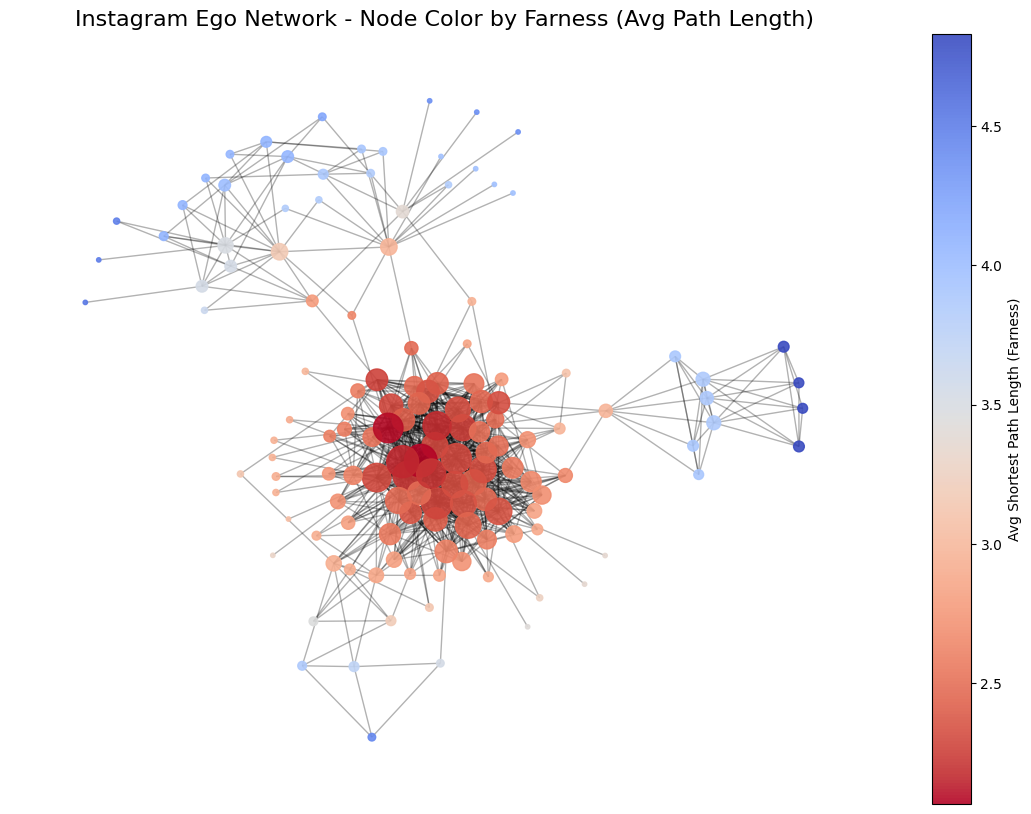

In [11]:
degree_dict = dict(G_largest.degree())

#Compute average shortest path length (farness) for each node
avg_path_length_per_node = {}
for node, targets in path_lengths.items():
    if len(targets) > 1:
        avg_path_length_per_node[node] = sum(targets.values()) / (len(targets) - 1)

#  Prepare node sizes and colors
node_sizes = [degree_dict[n] * 10 for n in G_largest.nodes()]  # Use degree to determine node size
node_colors = [avg_path_length_per_node.get(n, 0) for n in G_largest.nodes()]  # Use farness for node color

#  Define node positions (using Kamada-Kawai layout or any other layout)
pos = nx.kamada_kawai_layout(G_largest)

# Draw the network
plt.figure(figsize=(14, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos,
                                node_size=node_sizes,
                                node_color=node_colors,
                                cmap=plt.cm.coolwarm_r,
                                alpha=0.9)

nx.draw_networkx_edges(G_largest, pos, alpha=0.3)
plt.colorbar(nodes, label="Avg Shortest Path Length (Farness)")
plt.title("Instagram Ego Network - Node Color by Farness (Avg Path Length)", fontsize=16)
plt.axis("off")
plt.show()


Cooler-colored nodes (blue) are more central — they can reach others in fewer steps.

Warmer-colored nodes (red) are more peripheral — it takes longer to reach other users from them.

This highlights the core-periphery structure of your ego network.

## 8. Clustering Coefficient: Does the Network Show High Clustering?

The **clustering coefficient** measures the tendency of nodes to form **triangles** — i.e., how likely a user's friends are also friends with each other.

I compare the clustering coefficient of my Instagram ego network with that of a **random Erdős–Rényi (ER)** graph to check if my network shows **strong local clustering**, which is typical in social networks.

In [12]:
# Use the undirected version of the largest component
clustering_my_network = nx.average_clustering(G_largest)

# Clustering in random ER graph (undirected)
clustering_er = nx.average_clustering(er_largest)

print(f"My Network - Clustering Coefficient: {clustering_my_network:.3f}")
print(f"ER Random Graph - Clustering Coefficient: {clustering_er:.3f}")

My Network - Clustering Coefficient: 0.528
ER Random Graph - Clustering Coefficient: 0.116


### Interpretation:

- My network's **clustering coefficient** is **0.528**, compared to **0.117** in a random ER graph.
- This confirms that my Instagram friends tend to form **tightly-knit groups**, where friends of friends are often friends.
- Such a high clustering value is a classic indicator of **real social networks** and cannot be explained by random connections.

Conclusion: My Instagram ego network exhibits **strong local clustering**, validating the presence of **community structure**.


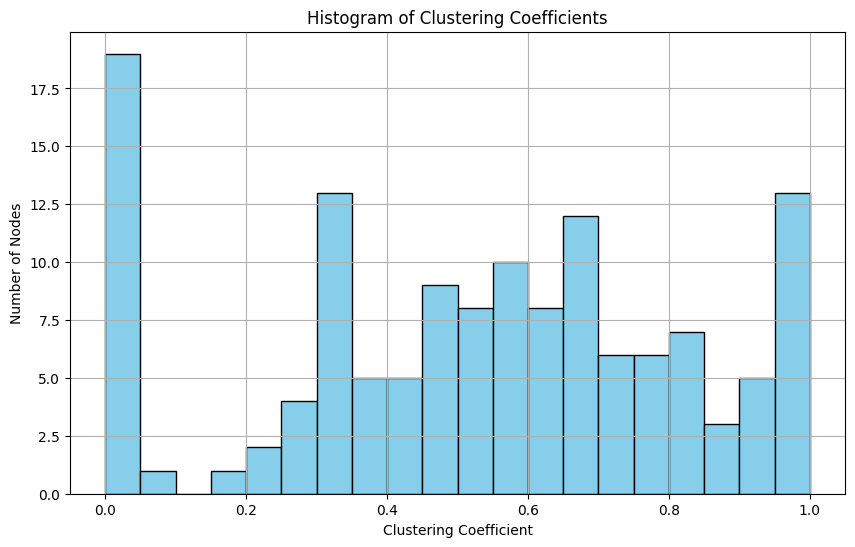

In [13]:
import matplotlib.pyplot as plt

# Clustering coefficient per node
clustering_per_node = nx.clustering(G_largest)

# Plot histogram of clustering coefficients
plt.figure(figsize=(10, 6))
plt.hist(clustering_per_node.values(), bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Clustering Coefficients")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

Most nodes have a high clustering coefficient, often near 1.0.

This supports the interpretation that users are embedded in tightly-knit groups, where many of their friends also follow each other.


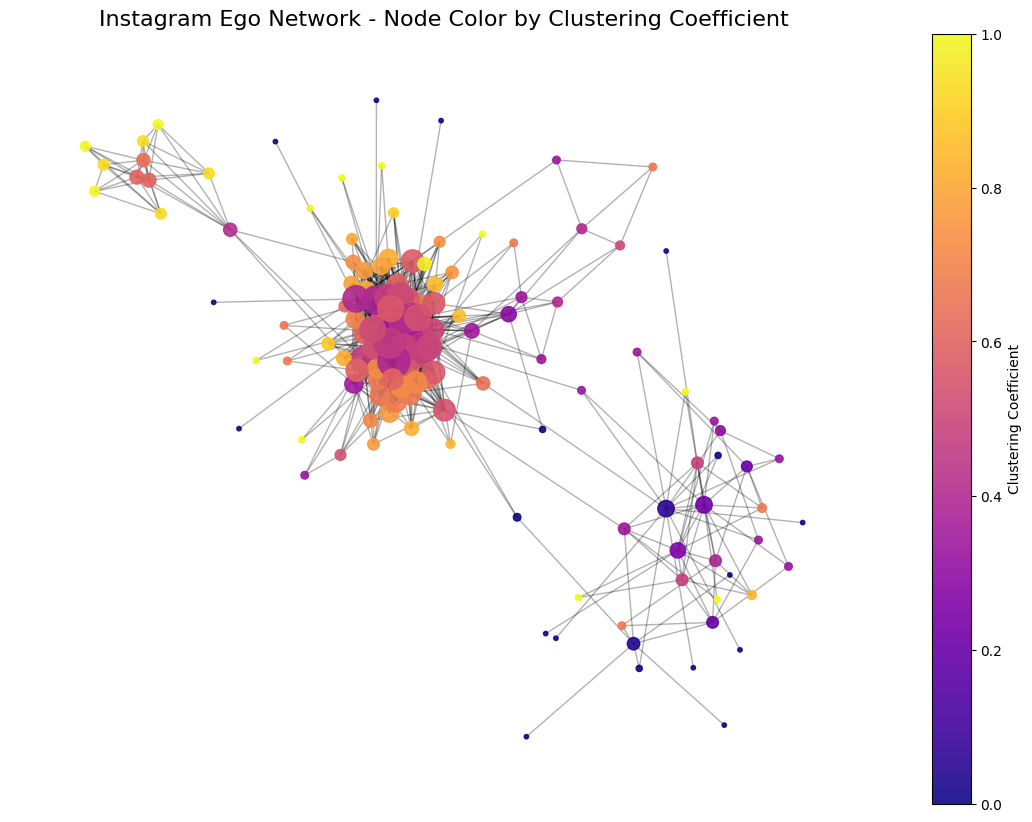

In [14]:
# Node sizes and colors
degree_dict = dict(G_largest.degree())
node_sizes = [degree_dict[n] * 10 for n in G_largest.nodes()]
node_colors = [clustering_per_node[n] for n in G_largest.nodes()]

# Spring layout
pos = nx.spring_layout(G_largest, k=0.25, iterations=50, seed=42)

# Plot the network
plt.figure(figsize=(14, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos,
                                node_size=node_sizes,
                                node_color=node_colors,
                                cmap=plt.cm.plasma,
                                alpha=0.9)

edges = nx.draw_networkx_edges(G_largest, pos, alpha=0.3)
plt.colorbar(nodes, label="Clustering Coefficient")
plt.title("Instagram Ego Network - Node Color by Clustering Coefficient", fontsize=16)
plt.axis("off")
plt.show()

Node color represents the clustering coefficient (brighter = higher clustering).

Node size is based on degree (larger nodes have more connections).

The layout shows clear clusters — groups of users with high internal connectivity.

## 9. Gorgeous Network Layout

This is the final visualization of my Instagram ego network. I use:

- **Spring layout** to emphasize structural organization
- **Node size** proportional to degree (connectivity)
- **Node color** based on clustering coefficient (community tightness)
- **Alpha transparency** to reduce visual clutter
- **Clean edges**, no labels, minimal distractions

This helps reveal:
- **Dense clusters** of friends
- **Bridge nodes** connecting different communities
- Overall network **structure and cohesiveness**

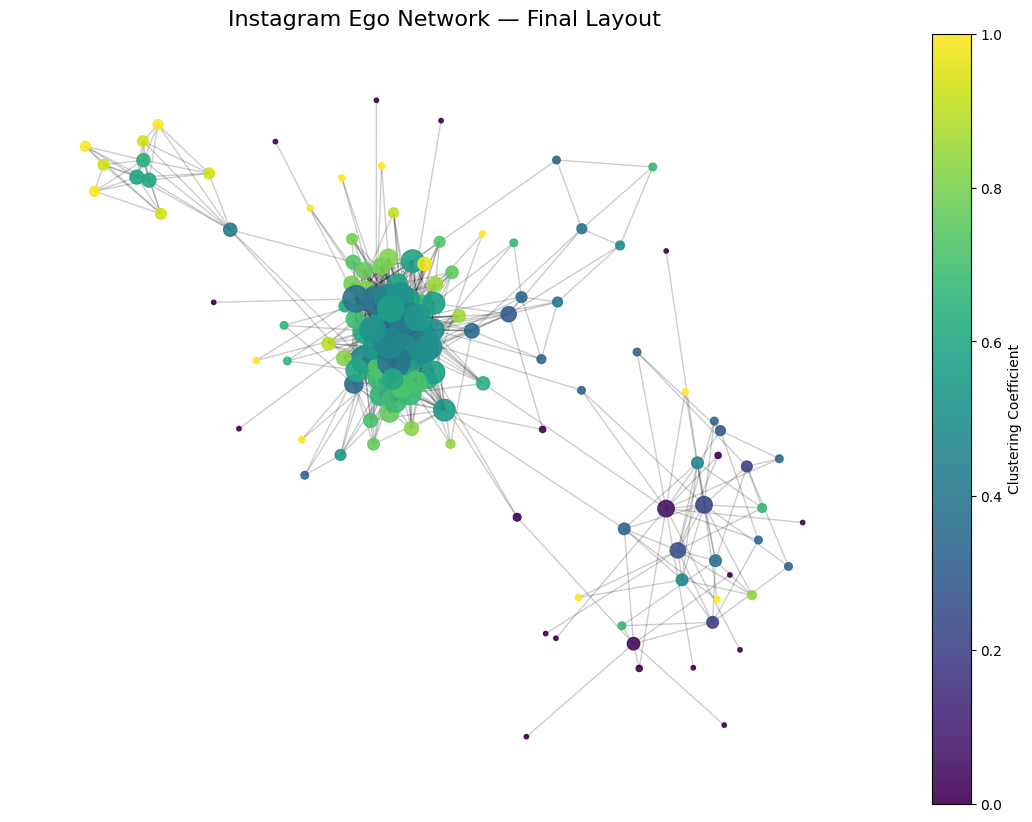

In [15]:
pos = nx.spring_layout(G_largest, k=0.25, iterations=50, seed=42)

# Sizes and colors
degree_dict = dict(G_largest.degree())
node_sizes = [degree_dict[n] * 10 for n in G_largest.nodes()]
node_colors = [nx.clustering(G_largest, n) for n in G_largest.nodes()]

# Plot
plt.figure(figsize=(14, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos,
                                node_size=node_sizes,
                                node_color=node_colors,
                                cmap=plt.cm.viridis,
                                alpha=0.9)

edges = nx.draw_networkx_edges(G_largest, pos, alpha=0.2)

plt.title("Instagram Ego Network — Final Layout", fontsize=16)
plt.colorbar(nodes, label="Clustering Coefficient")
plt.axis("off")
plt.show()

### Interpretation

- **Larger nodes** represent more connected users — likely influencers or active connectors.
- **Bright yellow/green nodes** show users in **highly clustered friend groups**.
- Clear **visual modularity** — users naturally form clusters, reflecting real friend circles.
- The layout confirms that the network has **rich structural patterns** beyond randomness.

This final layout visually summarizes key properties of the network:
- **Scale-free**
- **Small-world**
- **Highly clustered**
- **Community-rich**

In [16]:
# Export to GraphML for Gephi use
nx.write_graphml(G_largest, "instagram_ego_network.graphml")

# Structural analysis

## 1 — Compare with Network Models (ER, BA, WS)

To better understand the structure of my Instagram ego network, I compare it with three classic random network models:

- **Erdős–Rényi (ER)** – Random connections
- **Barabási–Albert (BA)** – Scale-free, hub-dominated
- **Watts–Strogatz (WS)** – Small-world, community-focused

Each model is evaluated on:
- Diameter
- Radius
- Average shortest path length
- Clustering coefficient

These metrics reveal how close each model is to my real ego network.

<ipython-input-17-d56c55a72634>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.max().max())


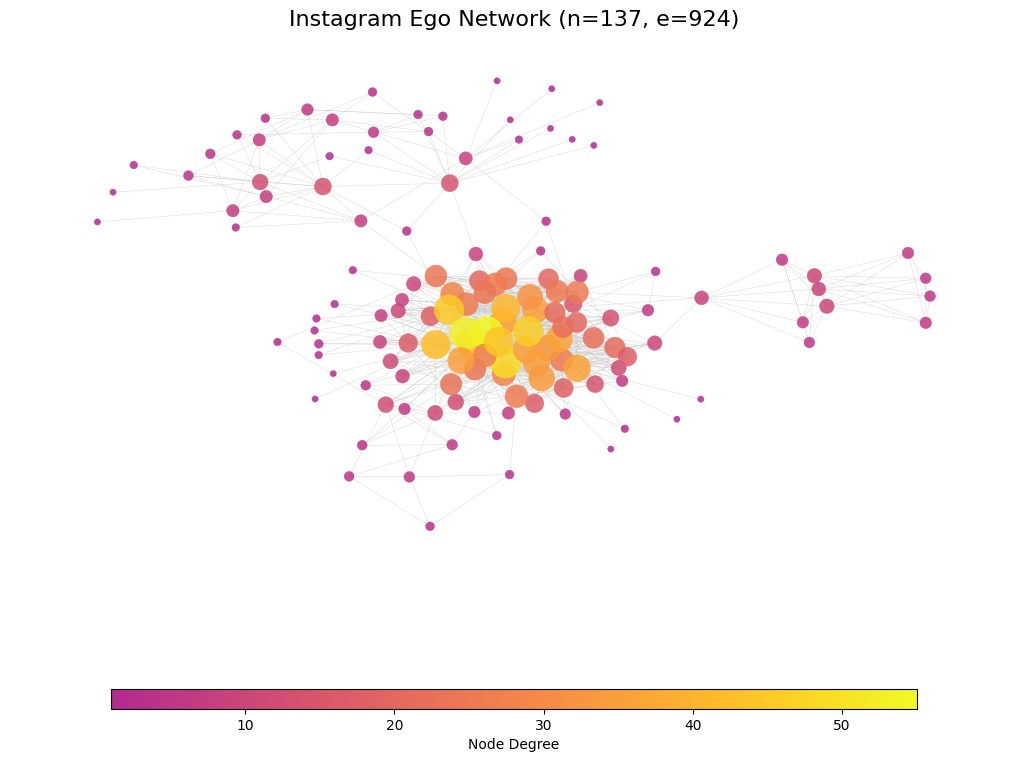

<ipython-input-17-d56c55a72634>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.max().max())


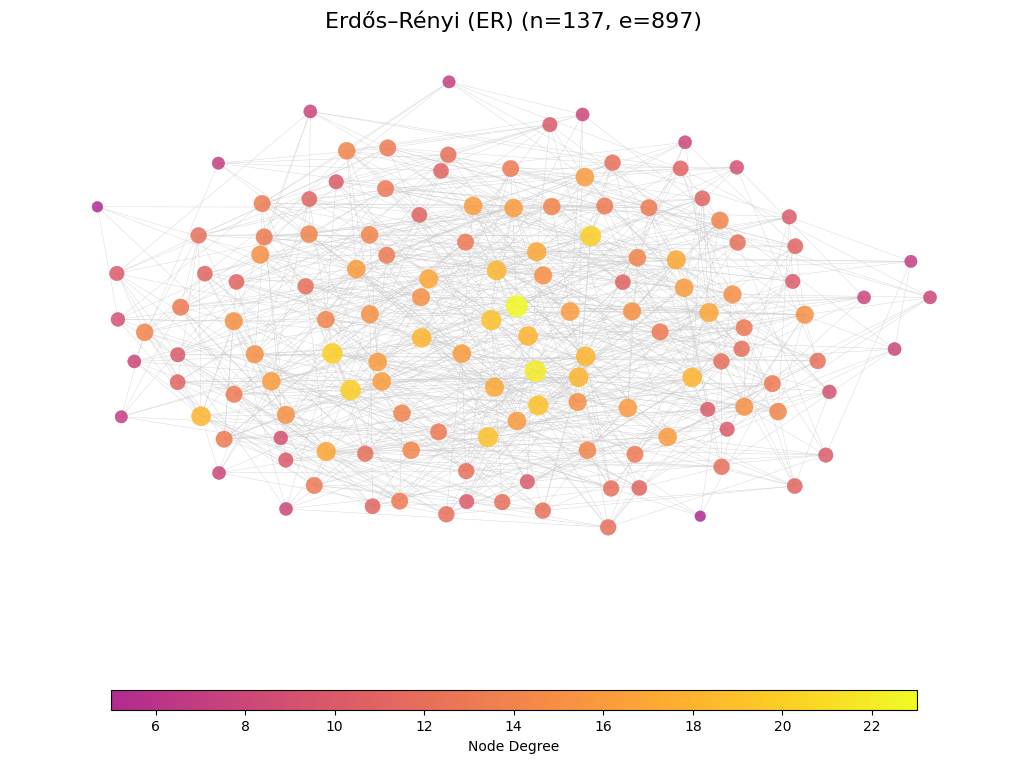

<ipython-input-17-d56c55a72634>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.max().max())


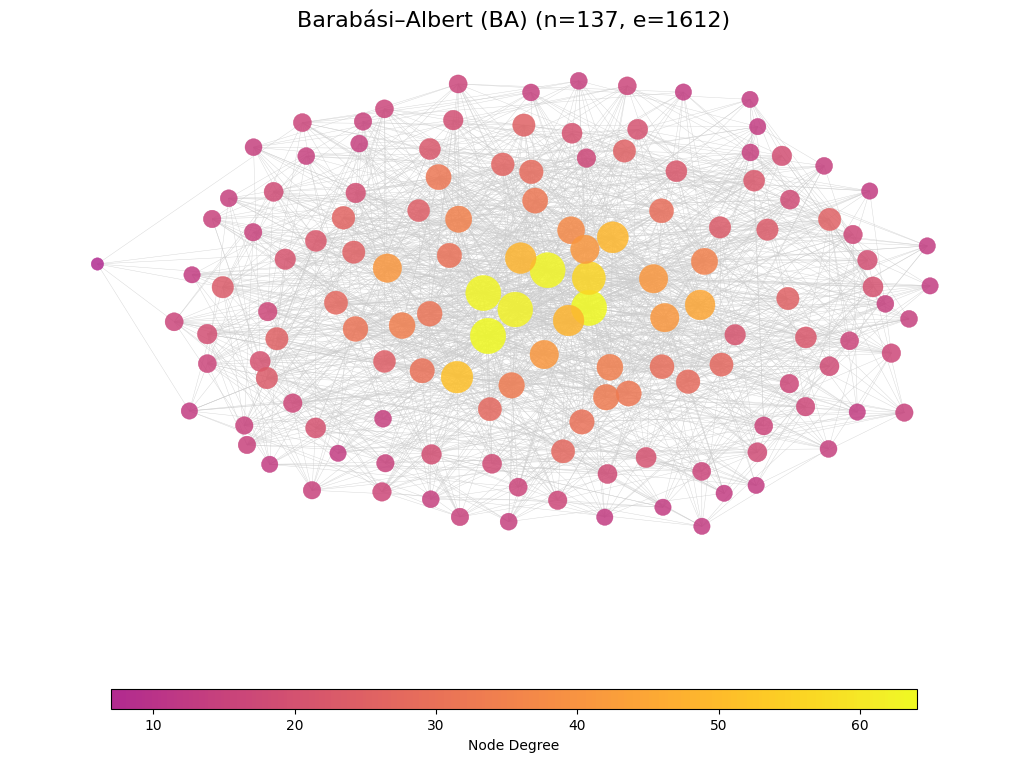

<ipython-input-17-d56c55a72634>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.max().max())


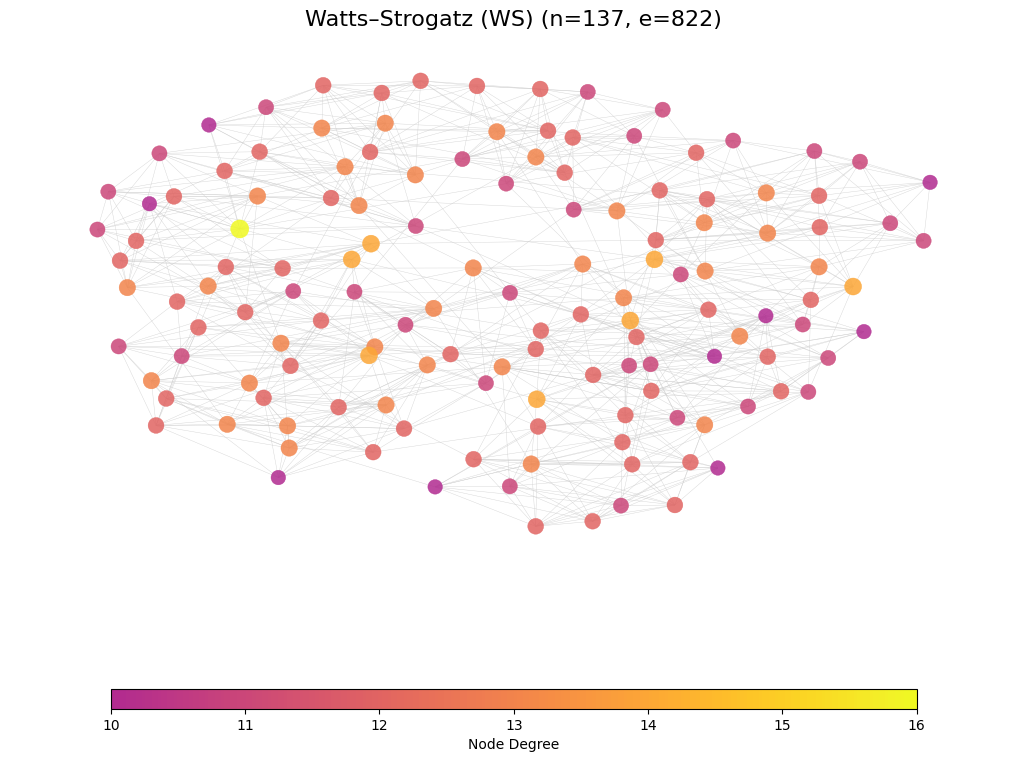

In [17]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Basic parameters
n_nodes = G_largest.number_of_nodes()
avg_deg = np.mean([d for _, d in G_largest.degree()])
prob = avg_deg / n_nodes

# Generate models
rgs = {
    "Instagram Ego Network": G_largest,
    "Erdős–Rényi (ER)": nx.fast_gnp_random_graph(n_nodes, prob, seed=1),
    "Barabási–Albert (BA)": nx.barabasi_albert_graph(n_nodes, int(avg_deg), seed=1),
    "Watts–Strogatz (WS)": nx.watts_strogatz_graph(n_nodes, int(avg_deg), p=0.1, seed=1)
}

# Helper to compute layout distance matrix
def pos_layout(g):
    df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
    for row, data in nx.shortest_path_length(g):
        for col, dist in data.items():
            df.loc[row, col] = dist
    df = df.fillna(df.max().max())
    return df

# Visualization with clustering layout
for name, rg in rgs.items():
    if not nx.is_connected(rg):
        rg = rg.subgraph(max(nx.connected_components(rg), key=len)).copy()

    df = pos_layout(rg)
    pos = nx.kamada_kawai_layout(rg, dist=df.to_dict())
    degrees = dict(rg.degree())
    node_sizes = [v * 10 + 10 for v in degrees.values()]
    cmap = ListedColormap(plt.cm.plasma(np.linspace(0.4, 1, 256)))
    norm = plt.Normalize(vmin=min(degrees.values()), vmax=max(degrees.values()))
    node_colors = [cmap(norm(degrees[n])) for n in rg.nodes()]

    fig, ax = plt.subplots(figsize=(13, 10))
    nx.draw(
        rg, pos=pos, node_size=node_sizes, edge_color="#cccccc", alpha=0.85,
        node_color=node_colors, linewidths=0.3, width=0.3, ax=ax
    )
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8, aspect=40)
    cbar.set_label('Node Degree')
    plt.title(f"{name} (n={len(rg)}, e={len(rg.edges())})", fontsize=16)
    plt.axis("off")
    plt.show()

In [18]:
import math
def graph_properties(g):
    if not nx.is_connected(g):
        g = g.subgraph(max(nx.connected_components(g), key=len)).copy()
    return {
        "Diameter": nx.diameter(g),
        "Radius": nx.radius(g),
        "Avg Shortest Path": round(nx.average_shortest_path_length(g), 3),
        "Avg Clustering": round(nx.average_clustering(g), 3)
    }

# GK scoring helper
def get_gk(expected, actual, sigma):
    return {
        k: math.exp(-(expected[k] - actual[k]) ** 2 / (2 * sigma[k] ** 2))
        for k in actual
    }

# Set up comparison
sigma = {
    "Diameter": 3,
    "Radius": 1,
    "Avg Shortest Path": 1,
    "Avg Clustering": 0.001
}

actual_props = graph_properties(G_largest)
gk_scores, metrics = {}, {}

for name, rg in rgs.items():
    props = graph_properties(rg)
    metrics[name] = props
    gk_scores[name] = get_gk(actual_props, props, sigma)

# Create DataFrames
model_df = pd.DataFrame(metrics).T
gk_df = pd.DataFrame(gk_scores).T
gk_df["Total Score"] = gk_df.mean(axis=1)
gk_df_sorted = gk_df.sort_values("Total Score", ascending=False)

# Show
from IPython.display import display

print("Model Structural Properties")
display(model_df)

print("\nGK Similarity Scores")
display(gk_df_sorted)

Model Structural Properties


Diameter  Radius  Avg Shortest Path  Avg Clustering
Instagram Ego Network       7.0     4.0              3.110           0.528
Erdős–Rényi (ER)            3.0     3.0              2.165           0.106
Barabási–Albert (BA)        3.0     2.0              1.855           0.267
Watts–Strogatz (WS)         4.0     3.0              2.702           0.515


GK Similarity Scores


Diameter    Radius  Avg Shortest Path  Avg Clustering  \
Instagram Ego Network  1.000000  1.000000           1.000000    1.000000e+00   
Watts–Strogatz (WS)    0.606531  0.606531           0.920138    2.005009e-37   
Erdős–Rényi (ER)       0.411112  0.606531           0.639856    0.000000e+00   
Barabási–Albert (BA)   0.411112  0.135335           0.454975    0.000000e+00   

                       Total Score  
Instagram Ego Network     1.000000  
Watts–Strogatz (WS)       0.533300  
Erdős–Rényi (ER)          0.414375  
Barabási–Albert (BA)      0.250356

### Interpretation
- My network shows **longer path lengths**, **high clustering**, and **moderate radius**.
- This reflects **community structure** and **hierarchical organization**.

- The **Watts–Strogatz (WS)** model is most similar in structure due to **clustering and moderate paths**.
- The **Barabási–Albert (BA)** model better captures **hub structure**, but lacks realistic clustering.
- **Erdős–Rényi (ER)** is not a good match — its structure is too random and flat.

**Conclusion**:  
My Instagram ego network combines **small-world clustering** and **scale-free degree distribution** — a hybrid structure, typical of real-world social networks.


## 2: Centrality Measures

Centrality measures identify **influential users** in the network — those who are well-connected, serve as bridges, or are close to everyone else.  
I compute and compare the **top 5 nodes** for the following:

- **Degree Centrality**: Raw connectivity
- **Betweenness Centrality**: Bridges between groups
- **Closeness Centrality**: Overall accessibility
- **Eigenvector Centrality**: Influence through connections

<ipython-input-17-d56c55a72634>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.max().max())


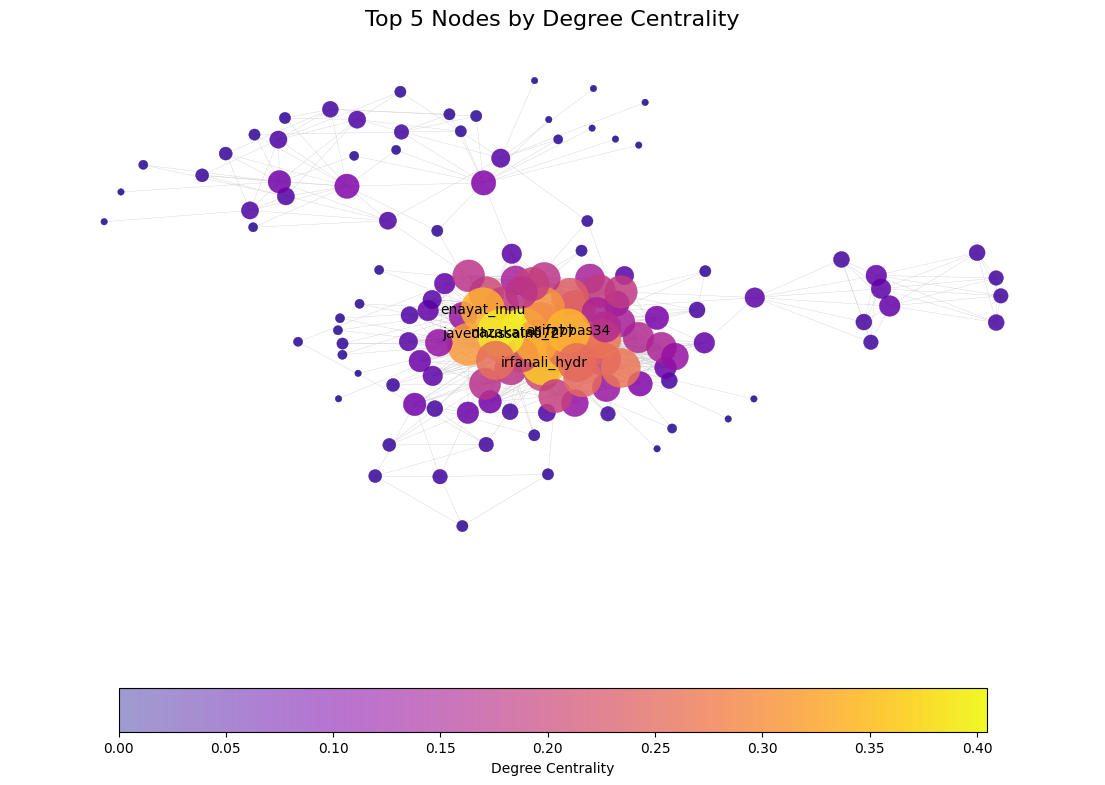


Top 5 by Degree Centrality:


Username  Degree Centrality
0   nazakatali_777           0.404412
1  javedhussain072           0.389706
2    irfanali_hydr           0.360294
3      asifabbas34           0.338235
4      enayat_innu           0.330882

Interpretation:
They have the most direct connections and likely influence many users directly.

--------------------------------------------------------------------------------


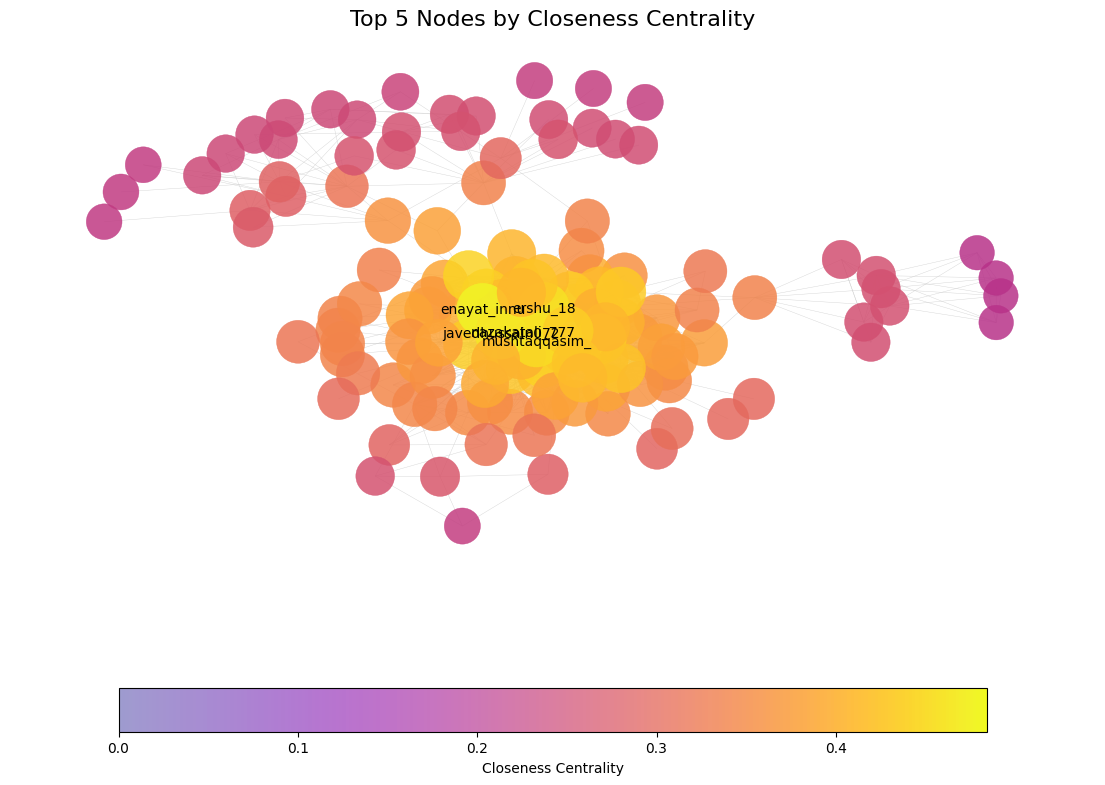


Top 5 by Closeness Centrality:


Username  Closeness Centrality
0   nazakatali_777              0.483986
1      enayat_innu              0.477193
2  javedhussain072              0.462585
3         ershu_18              0.457912
4    mushtaqqasim_              0.451827

Interpretation:
 They can quickly reach all other users, indicating high accessibility.

--------------------------------------------------------------------------------


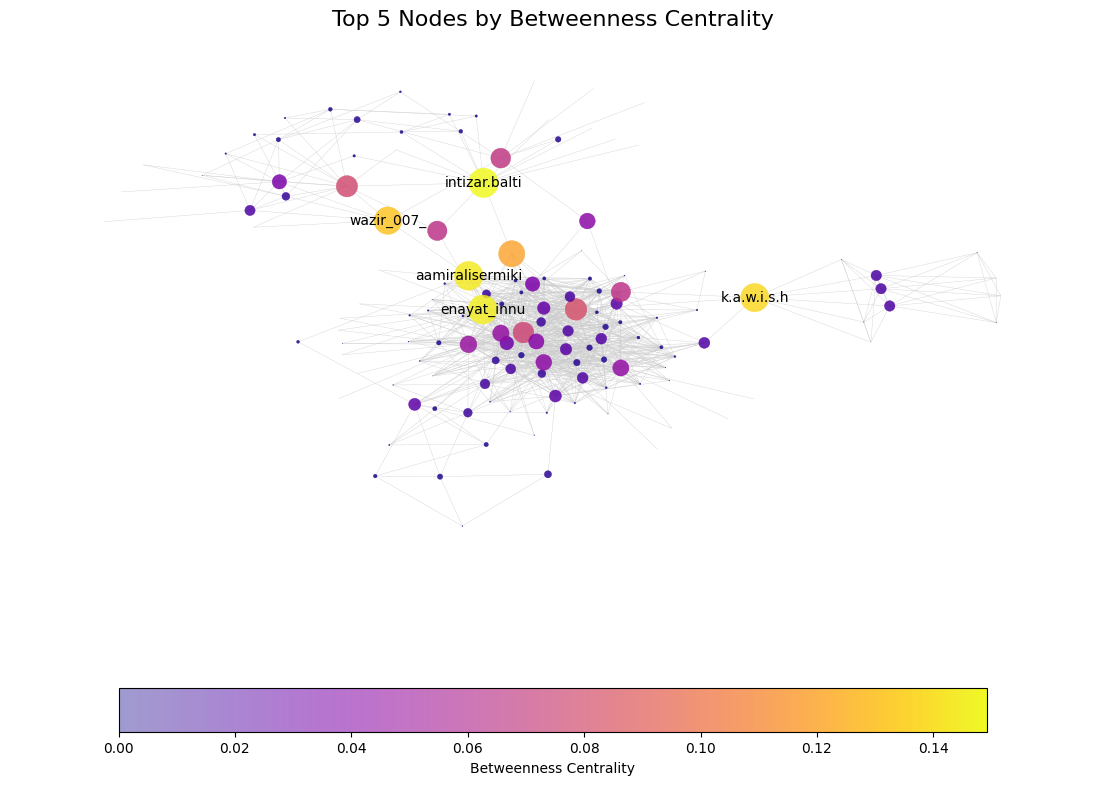


Top 5 by Betweenness Centrality:


Username  Betweenness Centrality
0    intizar.balti                0.149140
1      enayat_innu                0.145083
2  aamiralisermiki                0.143474
3      k.a.w.i.s.h                0.137367
4       wazir_007_                0.130752

Interpretation:
They act as bridges between communities, controlling flow between clusters.

--------------------------------------------------------------------------------


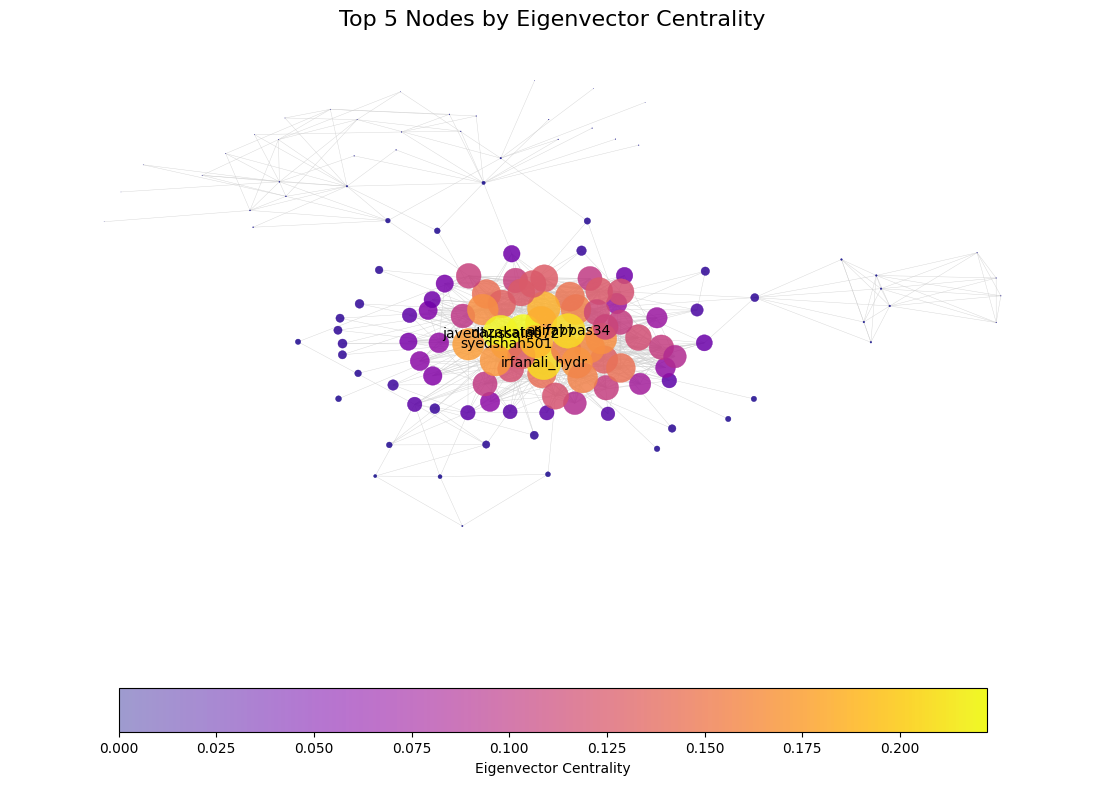


Top 5 by Eigenvector Centrality:


Username  Eigenvector Centrality
0   nazakatali_777                0.222138
1  javedhussain072                0.219166
2    irfanali_hydr                0.207038
3      asifabbas34                0.206784
4      syedshah501                0.194531

Interpretation:
They are connected to other well-connected and influential users — a recursive measure of influence.

--------------------------------------------------------------------------------


In [19]:
# Include Eigenvector Centrality in the analysis
centrality_types = {
    'Degree': nx.degree_centrality(G_largest),
    'Closeness': nx.closeness_centrality(G_largest),
    'Betweenness': nx.betweenness_centrality(G_largest),
    'Eigenvector': nx.eigenvector_centrality(G_largest, max_iter=500)
}

centrality_results = {}

# Layout for visualizations
pos = nx.kamada_kawai_layout(G_largest, dist=pos_layout(G_largest).to_dict())

# Custom colormap function
def customized_color(name_cmap, alpha=0.4):
    cmap = plt.get_cmap(name_cmap)
    custom_cmap = cmap(np.arange(cmap.N))
    custom_cmap[:, -1] = np.linspace(alpha, 1, cmap.N)
    return ListedColormap(custom_cmap)

# Generate centrality visualizations and top tables
for ctype, centrality in centrality_types.items():
    sorted_cent = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    top5 = sorted_cent[:5]
    top_nodes = {node: node for node, _ in top5}  # Labels = node names

    df = pd.DataFrame(top5, columns=["Username", f"{ctype} Centrality"])
    centrality_results[ctype] = df

    # Visualization
    node_sizes = [centrality[n] * 3000 for n in G_largest.nodes()]
    cmap = customized_color('plasma')
    norm = plt.Normalize(vmin=0, vmax=max(centrality.values()))
    node_colors = [cmap(norm(centrality[n])) for n in G_largest.nodes()]

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_title(f"Top 5 Nodes by {ctype} Centrality", fontsize=16)

    nx.draw(G_largest, pos,
            node_size=node_sizes,
            node_color=node_colors,
            edge_color="#cccccc",
            linewidths=0.3, width=0.3,
            alpha=0.85,
            ax=ax)

    nx.draw_networkx_labels(G_largest, pos=pos, labels=top_nodes, font_size=10, ax=ax)

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8)
    cbar.set_label(f"{ctype} Centrality")
    ax.axis("off")
    plt.show()

    # Show Top 5 Table
    print(f"\nTop 5 by {ctype} Centrality:")
    display(df)

    # Interpretation
    print(f"Interpretation:")
    if ctype == "Degree":
        print("They have the most direct connections and likely influence many users directly.")
    elif ctype == "Closeness":
        print(" They can quickly reach all other users, indicating high accessibility.")
    elif ctype == "Betweenness":
        print("They act as bridges between communities, controlling flow between clusters.")
    elif ctype == "Eigenvector":
        print("They are connected to other well-connected and influential users — a recursive measure of influence.")
    print("\n" + "-" * 80)

### Interpretation of Centrality Rankings:

####  Degree Centrality:
- **@nazakatali_777**, **@javedhussain072**, and **@irfanali_hydr** have the most connections — likely very **active**, **popular**, or **visible** users in the network.

####  Betweenness Centrality:
- **@intizar.balti**, **@enayat_innu**, and **@aamiralisermiki** act as **bridges** between friend groups.  
  These users connect otherwise separate communities and are **crucial for information flow**.

####  Closeness Centrality:
- **@nazakatali_777** and **@enayat_innu** again top the list, meaning they can **reach others quickly**.  
  These users are **central to the network’s structure** and have high communication efficiency.

####  Eigenvector Centrality:
- **@nazakatali_777** and **@javedhussain072** are highly connected to **other influential users** — not just popular, but **popular among the popular**.  
  They sit at the core of influence in the social graph.

---

**Overall Insight**:
- **@nazakatali_777** consistently ranks at the top across all centrality metrics — this user is a **hub**, a **connector**, and an **influencer**.
- Others like **@enayat_innu** and **@javedhussain072** also appear in multiple rankings, suggesting a **stable and important structural role** within the Instagram ego network.

## 3. Structural Analysis (Optional): PageRank & HITS – Directed Network Analysis

I extended the centrality analysis to directed graph algorithms:

- **PageRank**: Measures influence based on being linked by important nodes.
- **HITS**: Separates nodes into **Hubs** (linking to others) and **Authorities** (being linked by others).


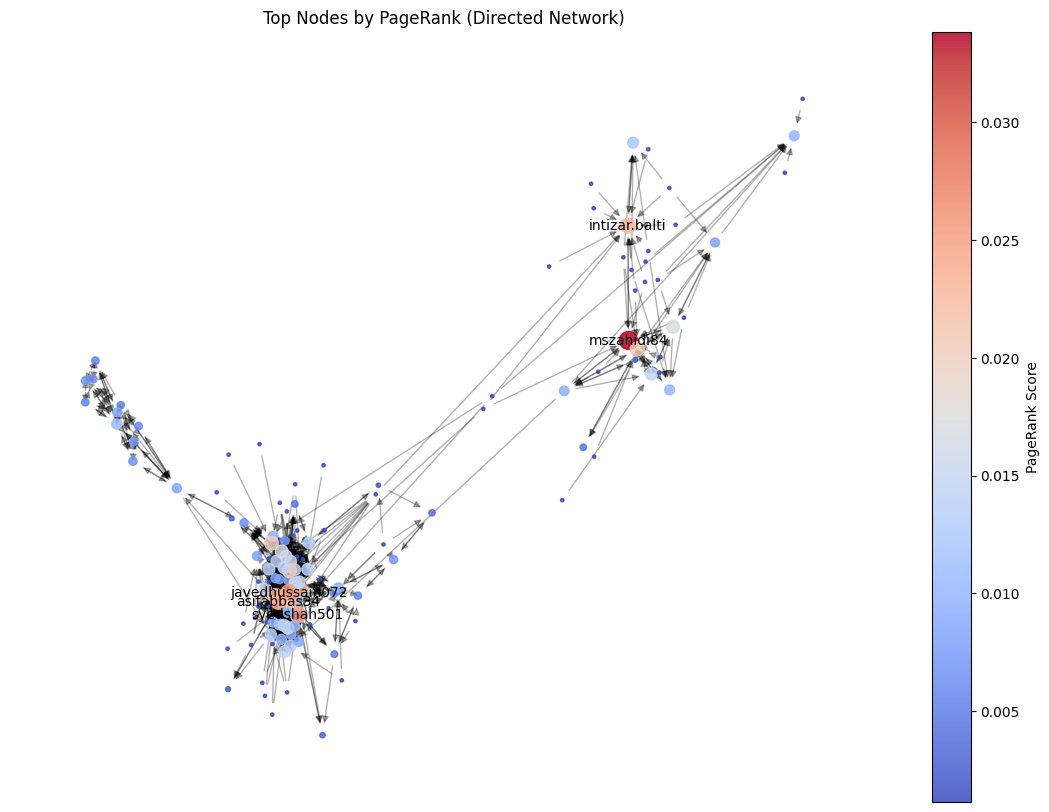

 Top 5 by PageRank:


Username  PageRank
0       mszahidi84  0.033842
1  javedhussain072  0.025154
2      syedshah501  0.024899
3      asifabbas34  0.024181
4    intizar.balti  0.023022


 Top 5 by HITS (Hub & Authority):


Username  HITS Hub  HITS Authority
0    irfanali_hydr  0.028440        0.038943
1   nazakatali_777  0.028307        0.038134
2      asifabbas34  0.026538        0.034870
3  javedhussain072  0.025526        0.033724
4         ershu_18  0.025309        0.032747

In [20]:
# Compute PageRank and HITS (on directed graph G)
pagerank_scores = nx.pagerank(G)
hits_hubs, hits_authorities = nx.hits(G)

# Get top 5 nodes by PageRank and HITS hub/authority scores
def top_n(dictionary, n=5):
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:n]

top_pagerank = top_n(pagerank_scores)
top_hits_hub = top_n(hits_hubs)
top_hits_auth = top_n(hits_authorities)

# Create DataFrame
pagerank_df = pd.DataFrame(top_pagerank, columns=["Username", "PageRank"])
hits_df = pd.DataFrame({
    "Username": [n for n, _ in top_hits_hub],
    "HITS Hub": [s for _, s in top_hits_hub],
    "HITS Authority": [s for _, s in top_hits_auth]
})

# Layout for directed network (subset if too dense)
G_vis = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()
pos = nx.spring_layout(G_vis, seed=42)

# Color by PageRank
pr_values = pagerank_scores
node_sizes = [pr_values[n] * 5000 for n in G_vis.nodes()]
node_colors = [pr_values[n] for n in G_vis.nodes()]
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = plt.cm.coolwarm

# Plot PageRank layout
plt.figure(figsize=(14, 10))
nodes = nx.draw_networkx_nodes(G_vis, pos,
                                node_size=node_sizes,
                                node_color=node_colors,
                                cmap=cmap,
                                alpha=0.85)
nx.draw_networkx_edges(G_vis, pos, alpha=0.3)
labels = {n: n for n, _ in top_pagerank}
nx.draw_networkx_labels(G_vis, pos, labels, font_size=10)
plt.colorbar(nodes, label="PageRank Score")
plt.title("Top Nodes by PageRank (Directed Network)")
plt.axis("off")
plt.show()

# Show tables
print(" Top 5 by PageRank:")
display(pagerank_df)

print("\n Top 5 by HITS (Hub & Authority):")
display(hits_df)



**Interpretation**:
- **@mszahidi84** leads the PageRank — they are followed by or connected to highly influential users.
- Others like **@javedhussain072** and **@asifabbas34** consistently appear across centrality rankings, confirming strong influence.

- **Hubs**: Users like **@irfanali_hydr** and **@nazakatali_777** connect to many important nodes.
- **Authorities**: These users are often cited or followed — trusted figures in the network.


**Overall Insight**:
- PageRank and HITS reinforce earlier results.
- Users like **@asifabbas34**, **@javedhussain072**, and **@nazakatali_777** appear in multiple roles — they’re not just connected, but **strategically important**.

These advanced centralities offer deeper insight into **directed influence and connectivity**.

# 4. Structural Analysis (Optional): Degree Mixing Pattern

I analyzed the degree assortativity of my Instagram ego network.


### Degree Assortativity Coefficient: **+0.086**

This value is slightly positive, indicating **weak assortative mixing** by degree.

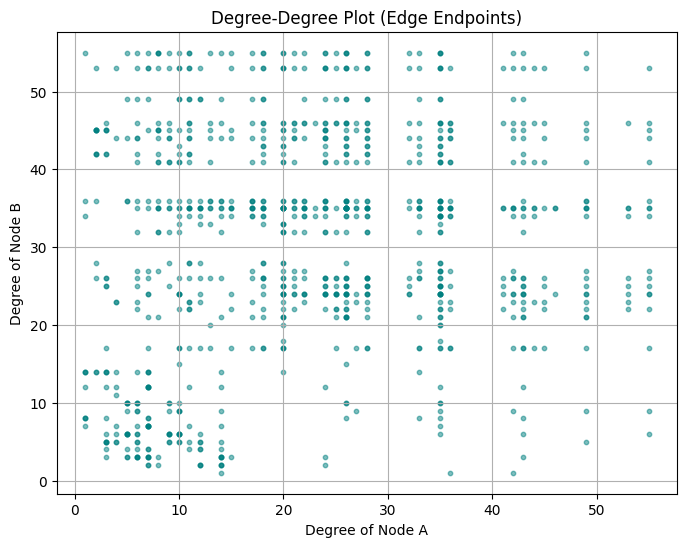

0.08571612917265749

In [21]:
# Calculate degree assortativity for the largest component
assortativity_coeff = nx.degree_assortativity_coefficient(G_largest)

# Compute degree for all nodes
degree_dict = dict(G_largest.degree())

# Create lists of source and target degrees for each edge
edge_degrees = [(degree_dict[u], degree_dict[v]) for u, v in G_largest.edges()]

# Separate source and target degrees
x, y = zip(*edge_degrees)

# Scatter plot of degree pairs
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, s=10, color='teal')
plt.title("Degree-Degree Plot (Edge Endpoints)")
plt.xlabel("Degree of Node A")
plt.ylabel("Degree of Node B")
plt.grid(True)
plt.show()

assortativity_coeff

### Interpretation:
- **Assortative mixing** means that high-degree nodes tend to connect with other high-degree nodes.
- In my case, the small positive value suggests that **popular users slightly prefer other popular users** — but the tendency is weak.
- The scatterplot of node degrees across edges shows **a loose cluster** — not strongly structured.

**Conclusion**:
- The network is **weakly assortative**, which is common in real social networks where influencers often follow or interact with each other.
- However, the weak value also reflects **cross-group connections**, where users interact across popularity levels.

# 5.(Optional) Attributes mixing pattern. Why is your network assortative/disassortative by node attributes?


 Assortativity for 'is_private':
   Assortativity coefficient: -0.034
   Top attribute values:
False    125
True      12
Name: count, dtype: int64


<ipython-input-22-62d8d6103dc7>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


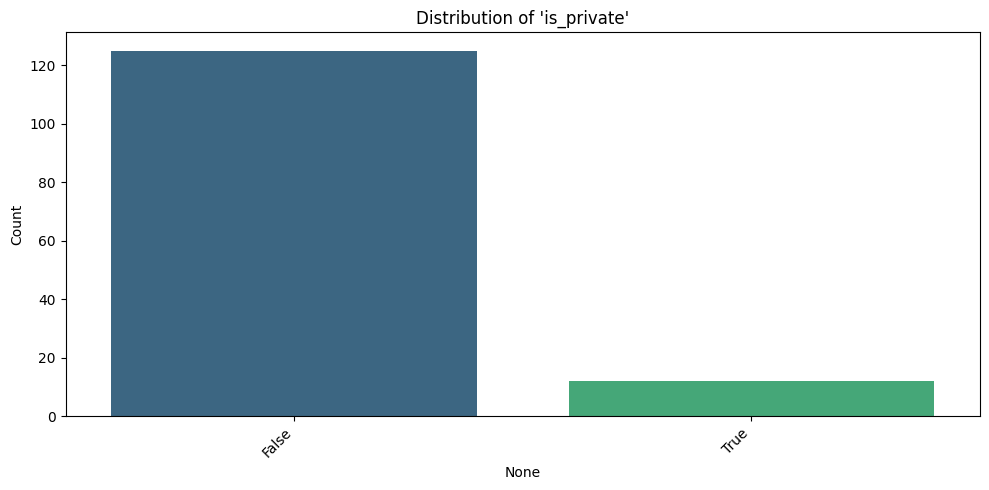

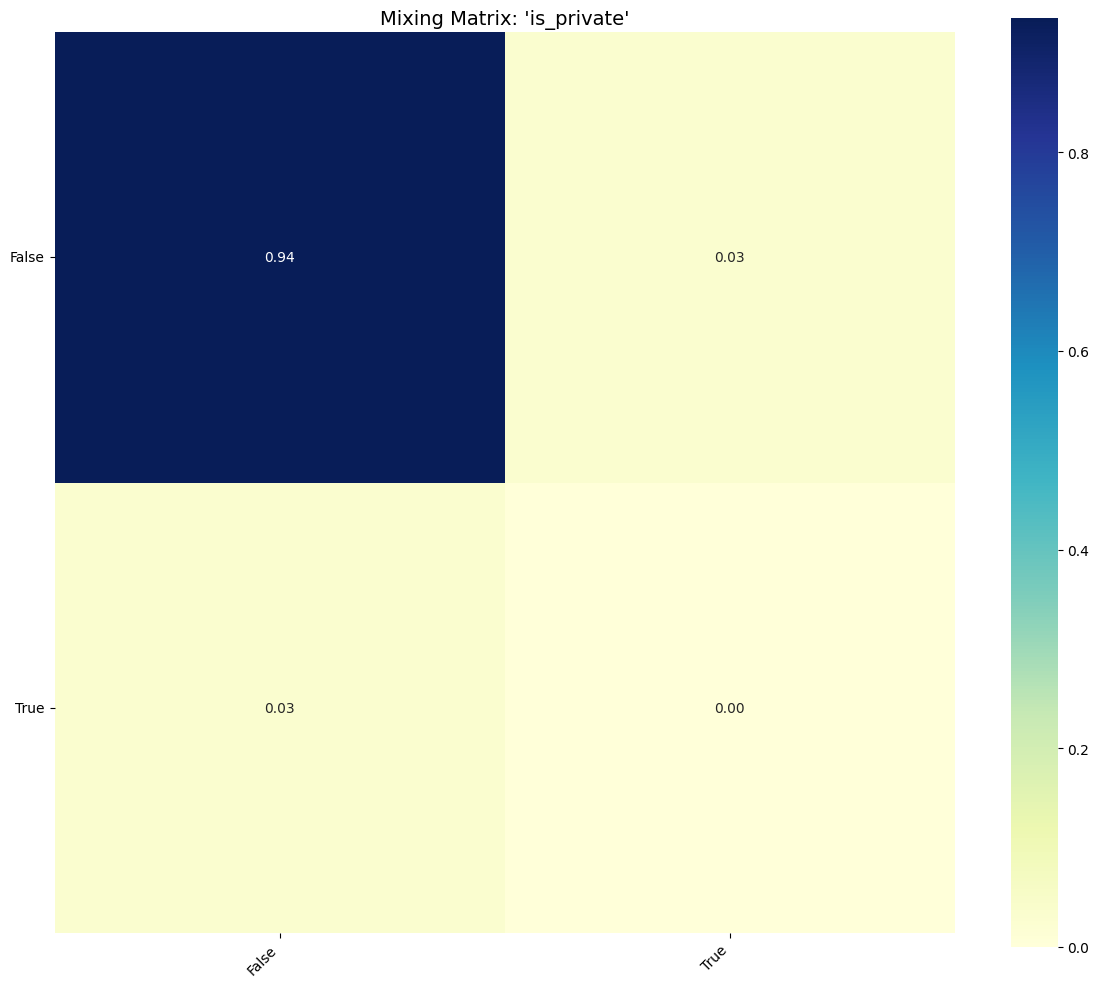


 Assortativity for 'location':
   Assortativity coefficient: 0.212
   Top attribute values:
kharmang    33
skardu      31
gilgit      25
mirpur      13
khaplu      11
kpk          4
lahore       3
diamar       3
shigar       2
turkey       2
Name: count, dtype: int64


<ipython-input-22-62d8d6103dc7>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


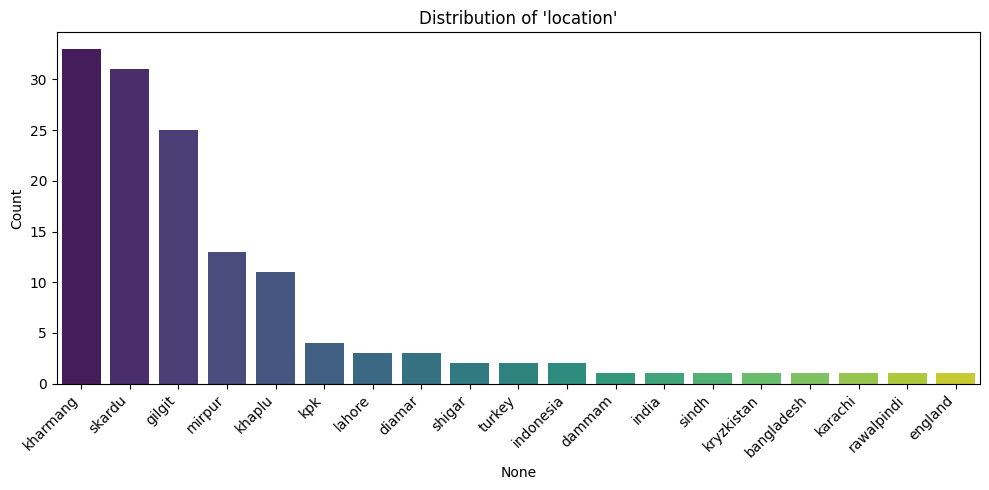

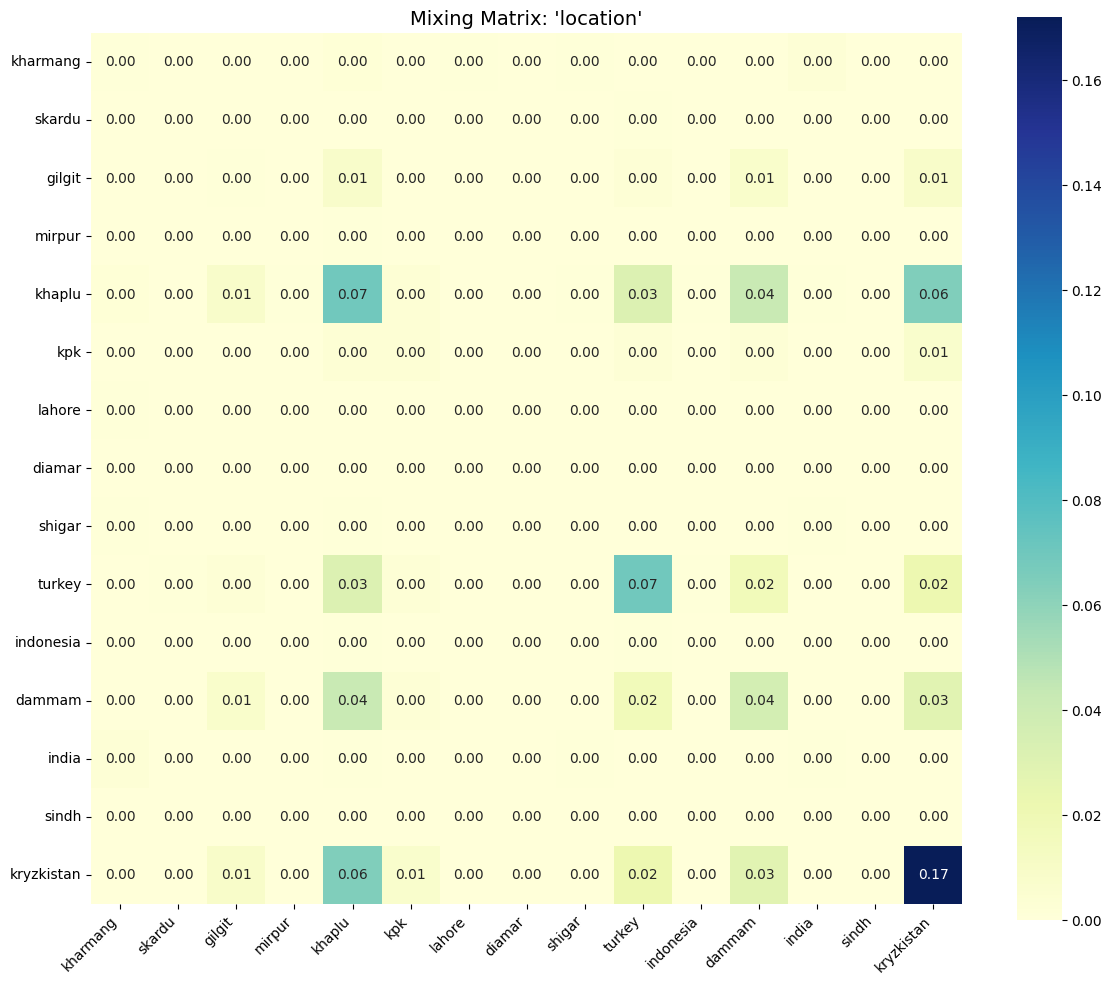


 Assortativity for 'follower_count':
   Assortativity coefficient: 0.012
   Top attribute values:
≤ 500      37
≤ 250      33
≤ 1000     27
≤ 100      20
≤ 5000     19
≤ 10000     1
Name: count, dtype: int64


<ipython-input-22-62d8d6103dc7>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


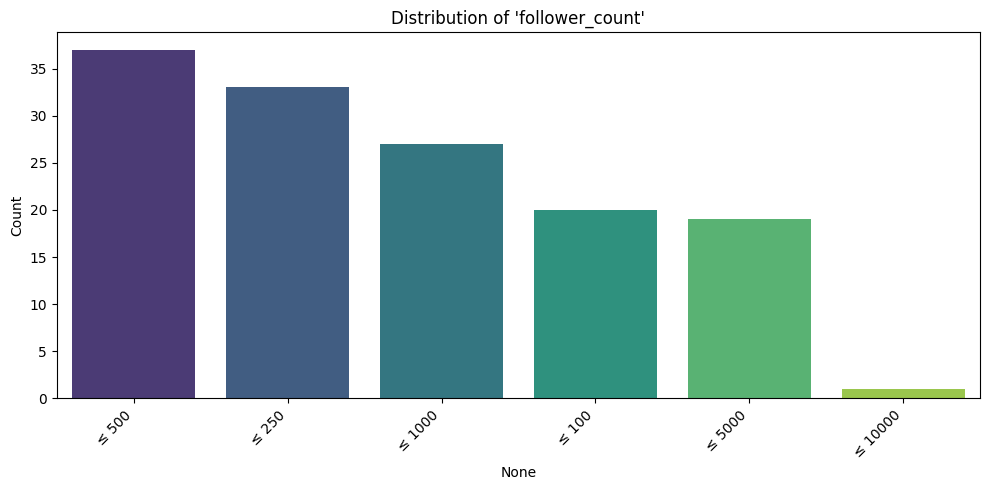

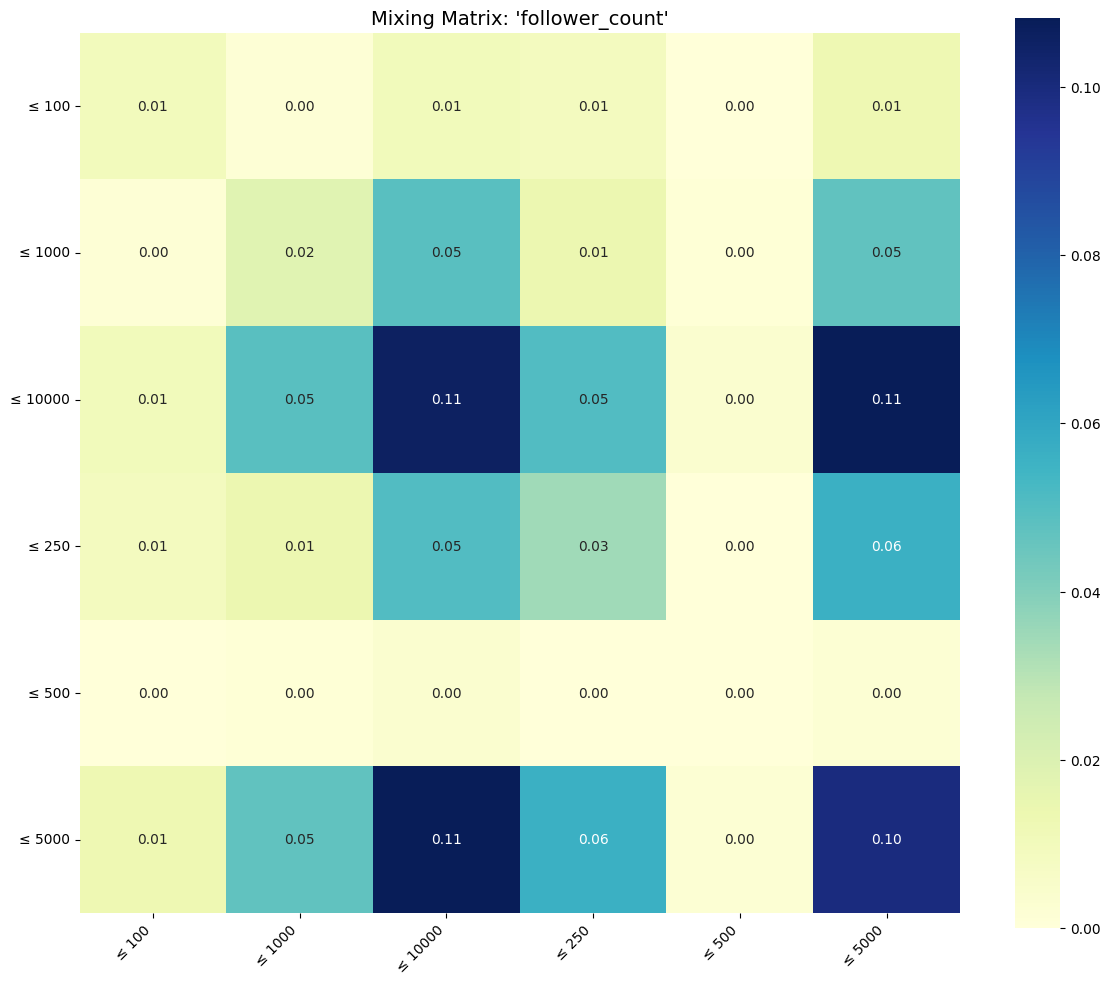


 Assortativity for 'main_context':
   Assortativity coefficient: 0.673
   Top attribute values:
must_university     83
hometown            18
pakistani           18
relatives            8
hse_university       6
sports_fans          3
gilgit_baltistan     1
Name: count, dtype: int64


<ipython-input-22-62d8d6103dc7>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


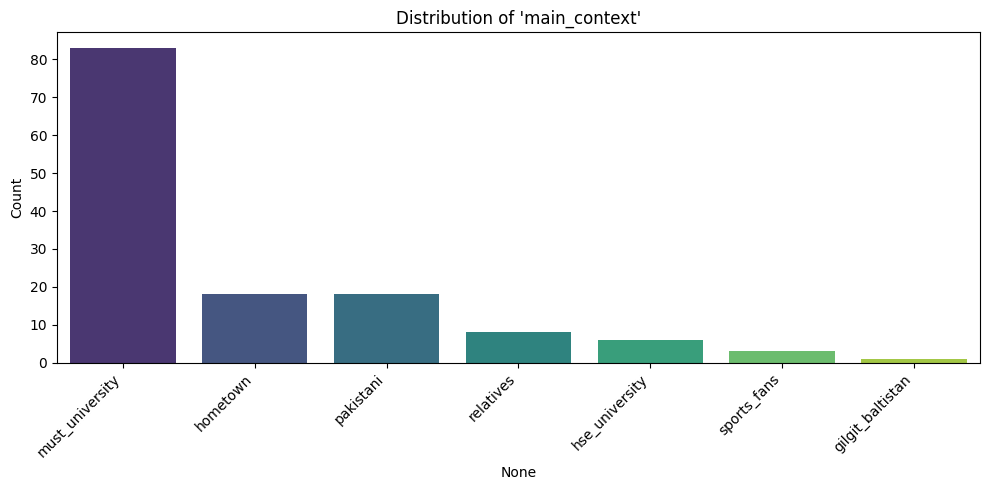

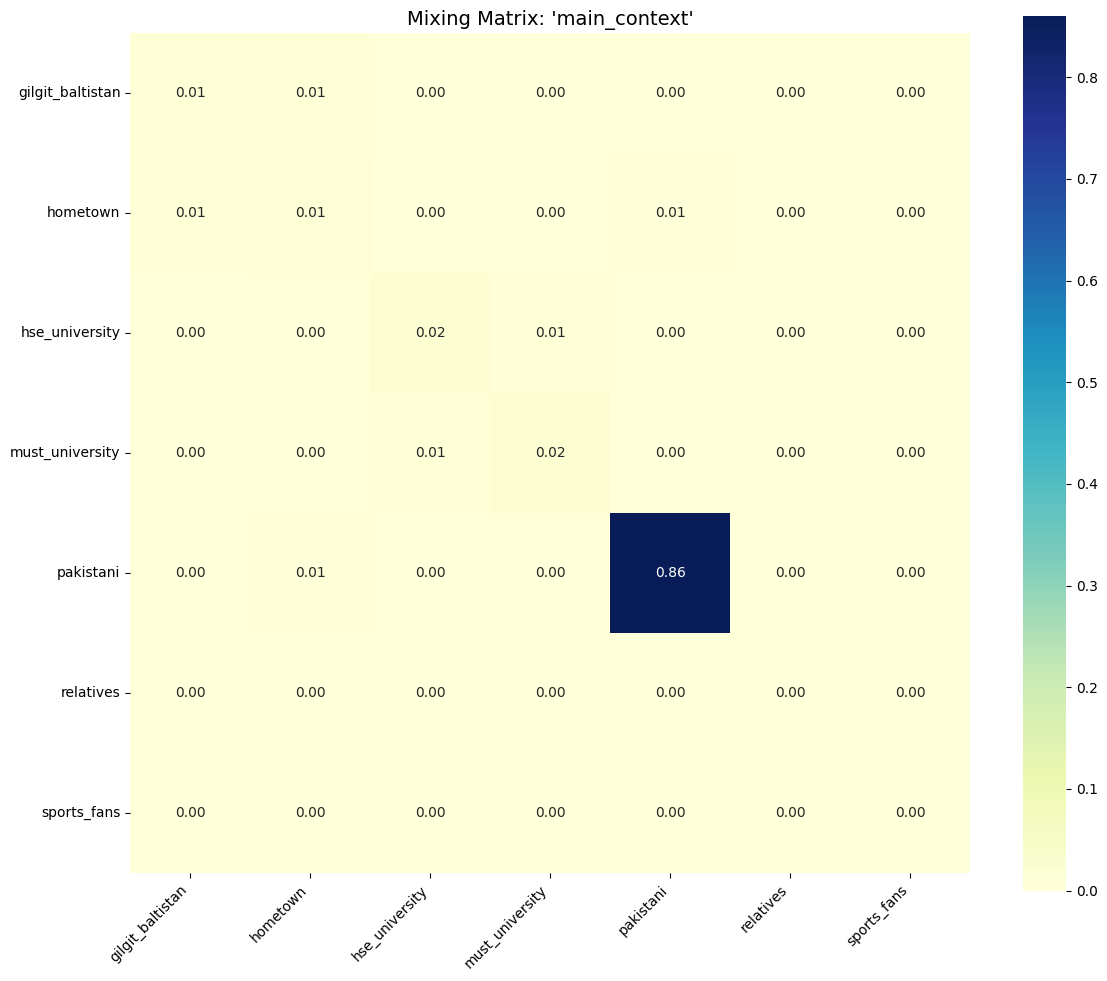


 Assortativity for 'social_context':
   Assortativity coefficient: 0.029
   Top attribute values:
university_friends, iso, kku, must_university, pakistani, gilgit_baltistan                 13
mehdiabad, hometown, pakistani, gilgit_baltistan                                            9
kku, must_university, university_friends, pakistani, gilgit_baltistan                       8
kku, must_university, pakistani, gilgit_baltistan                                           8
must_university, pakistani                                                                  7
moscow_connections, hse_university, dorm_mate                                               5
iso, kku, must_university, university_friends, pakistani, gilgit_baltistan                  5
hometown, mehdiabad, pakistani, gilgit_baltistan                                            5
iso, hostel_mate, kku, must_university, university_friends, pakistani, gilgit_baltistan     4
pakistani, gilgit_baltistan                            

<ipython-input-22-62d8d6103dc7>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")
<ipython-input-22-62d8d6103dc7>:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


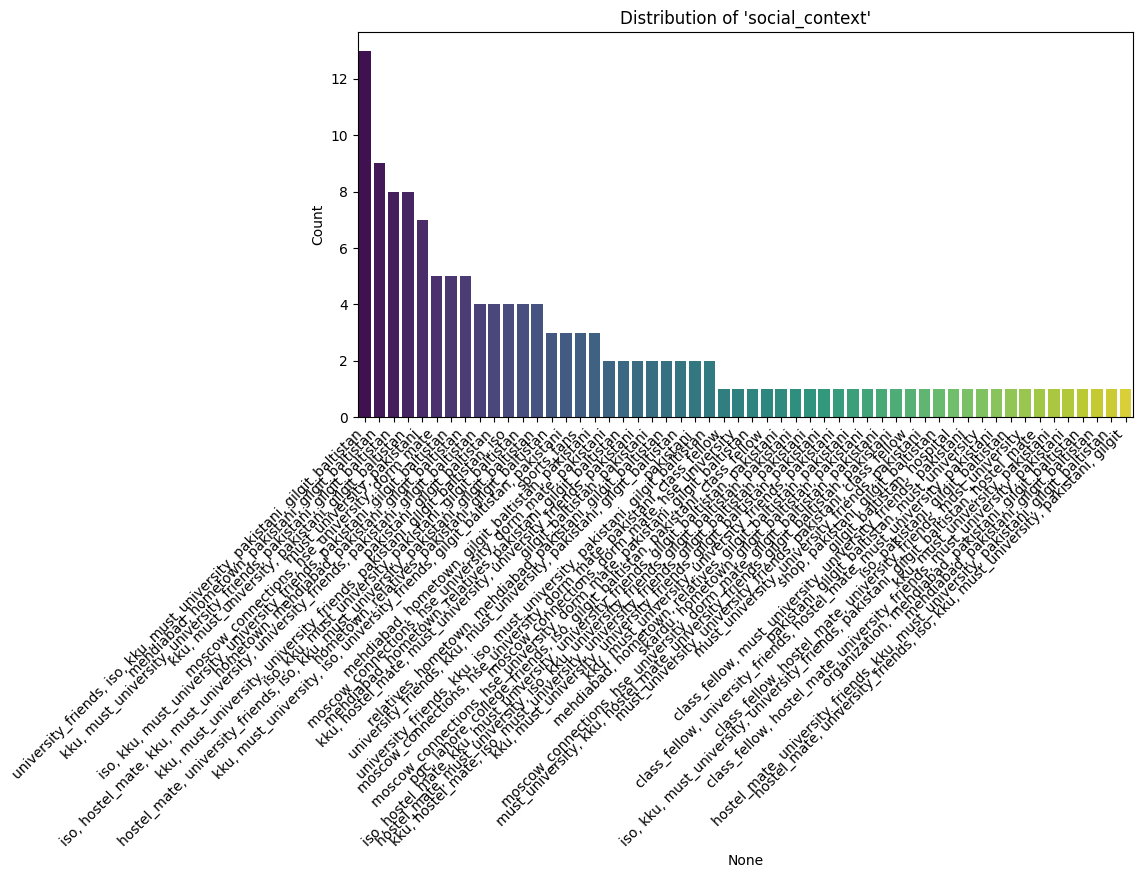

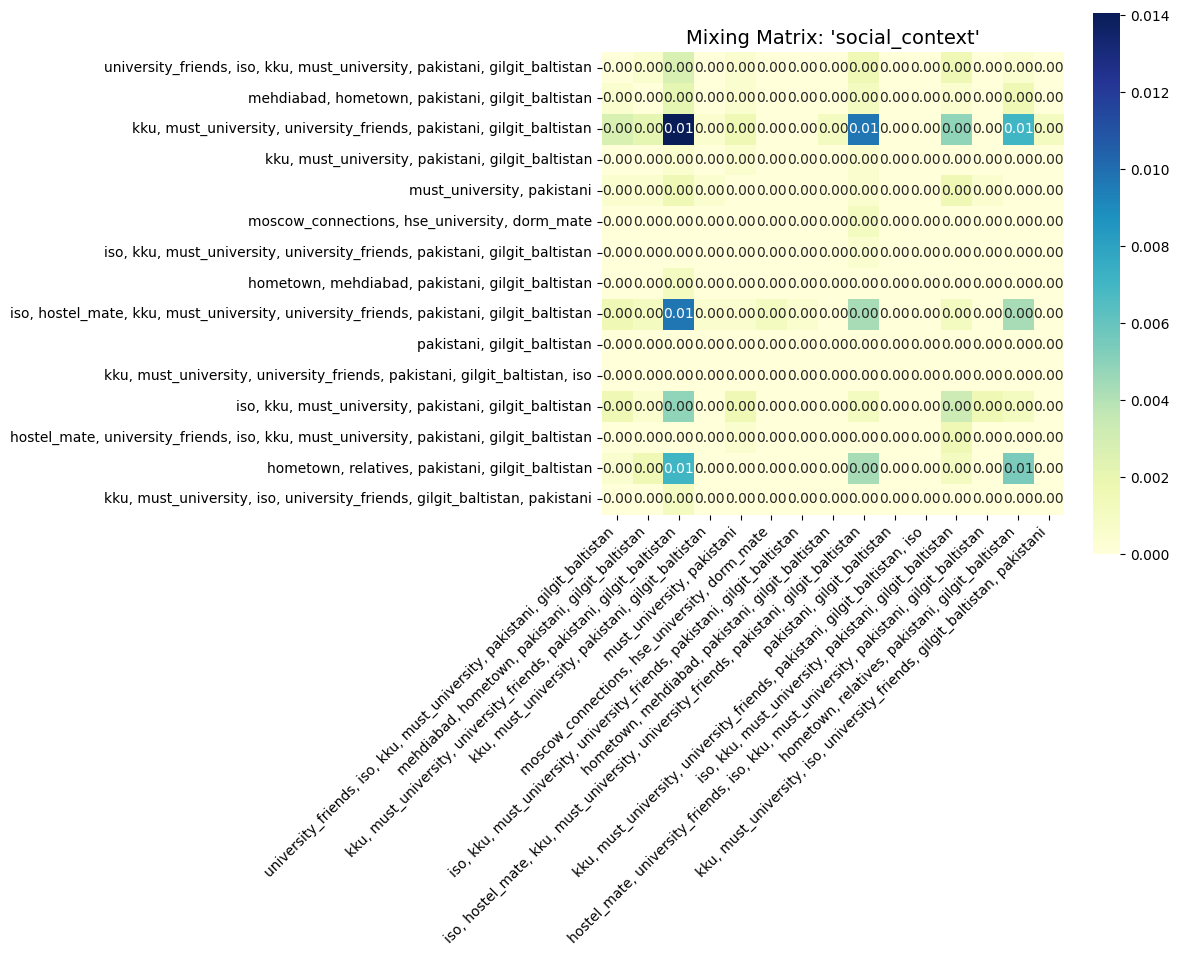

In [22]:
import seaborn as sns

#attribute mixing pattern including prioritized 'main_context' logic

def compute_and_plot_assortativity(G, attribute, bins=None, split_tags=False, top_n_matrix=15):
    print(f"\n Assortativity for '{attribute}':")

    # --- Prioritize main_context based on social_context if needed ---
    if attribute == "main_context":
        priority_tags = [
            "relatives", "hometown", "must_university", "university_friends",
            "pakistani", "gilgit_baltistan", "hse_university", "kku"
        ]
        for node, data in G.nodes(data=True):
            tags = data.get("social_context")
            if isinstance(tags, str):
                tag_list = [tag.strip().lower() for tag in tags.split(",") if tag.strip()]
                for priority in priority_tags:
                    if priority in tag_list:
                        data["main_context"] = priority
                        break
                else:
                    if tag_list:
                        data["main_context"] = tag_list[0]
            else:
                data["main_context"] = None

    # --- Binning for follower count if needed ---
    if bins and attribute == 'follower_count':
        for node, data in G.nodes(data=True):
            val = data.get(attribute, 0)
            for b in bins:
                if val <= b:
                    data[f"binned_{attribute}"] = f"≤ {b}"
                    break
            else:
                data[f"binned_{attribute}"] = f"> {bins[-1]}"
        attr = f"binned_{attribute}"
    else:
        attr = attribute

    # --- Assortativity calculation ---
    try:
        r = nx.attribute_assortativity_coefficient(G.to_undirected(), attr)
        print(f"   Assortativity coefficient: {r:.3f}")
    except Exception as e:
        print(f"   Could not compute assortativity for '{attr}': {e}")
        return

    # --- Attribute distribution ---
    values = [data.get(attr) for _, data in G.nodes(data=True) if attr in data and data.get(attr) is not None]
    if len(values) == 0:
        print(f"   No valid data found for '{attr}' to plot.")
        return

    counts = pd.Series(values).value_counts()
    print(f"   Top attribute values:\n{counts.head(10)}")

    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title(f"Distribution of '{attribute}'")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Mixing matrix heatmap ---
    try:
        matrix = nx.attribute_mixing_matrix(G.to_undirected(), attribute=attr)
        labels = sorted(set(values))
        if len(labels) > top_n_matrix:
            value_counts = pd.Series(values).value_counts()
            top_labels = value_counts.head(top_n_matrix).index.tolist()
            label_indices = [labels.index(l) for l in top_labels]
            matrix = matrix[np.ix_(label_indices, label_indices)]
            labels = top_labels

        plt.figure(figsize=(12, 10))
        sns.heatmap(matrix[:len(labels), :len(labels)], annot=True, square=True, fmt=".2f", cmap="YlGnBu",
                    xticklabels=labels, yticklabels=labels)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.title(f"Mixing Matrix: '{attribute}'", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   Heatmap error: {e}")

# Execute for all key attributes
follower_bins = [100, 250, 500, 1000, 5000, 10000]
attribute_groups = [
    ('is_private', None),
    ('location', None),
    ('follower_count', follower_bins),
    ('main_context', None),
    ('social_context', None)
]

for attr, bins in attribute_groups:
    compute_and_plot_assortativity(G_largest, attr, bins=bins)

I analyzed assortative mixing on node-level attributes to examine **homophily** patterns — how likely people with similar attributes are connected.

####  Strongest Mixing:
- `main_context` (assortativity = **+0.673**): people mostly connect within their key social identities (university, relatives, hometown).
- Diagonal heatmap dominance confirms strong within-group clustering.

#### Moderate:
- `location` (+0.212): suggests regional clustering (e.g. people from `Skardu`, `Gilgit` tend to cluster).

#### Weak/None:
- `follower_count`, `is_private`, and raw `social_context` tags had near-zero or slightly negative values, implying **no strong homophily**.

**Conclusion**:
- **Contextual social identity** is the strongest factor in shaping network structure.
- Other metadata (like follower count or account privacy) had little to no impact.

#6. (Optional) Structural similarity. Why does the node similarity matrix look the way it is?

To evaluate **how similar users are in terms of their connections**, I computed multiple structural similarity matrices:

### Techniques Used:
- **Adjacency Matrix**: Direct connections (edges)
- **Pearson Correlation**: Row-wise correlation of adjacency
- **Jaccard Similarity**: Overlap of neighbor sets
- **Cosine Similarity**: Angular similarity between adjacency vectors
- **RCM Reordering**: Used to clarify block structure in matrices



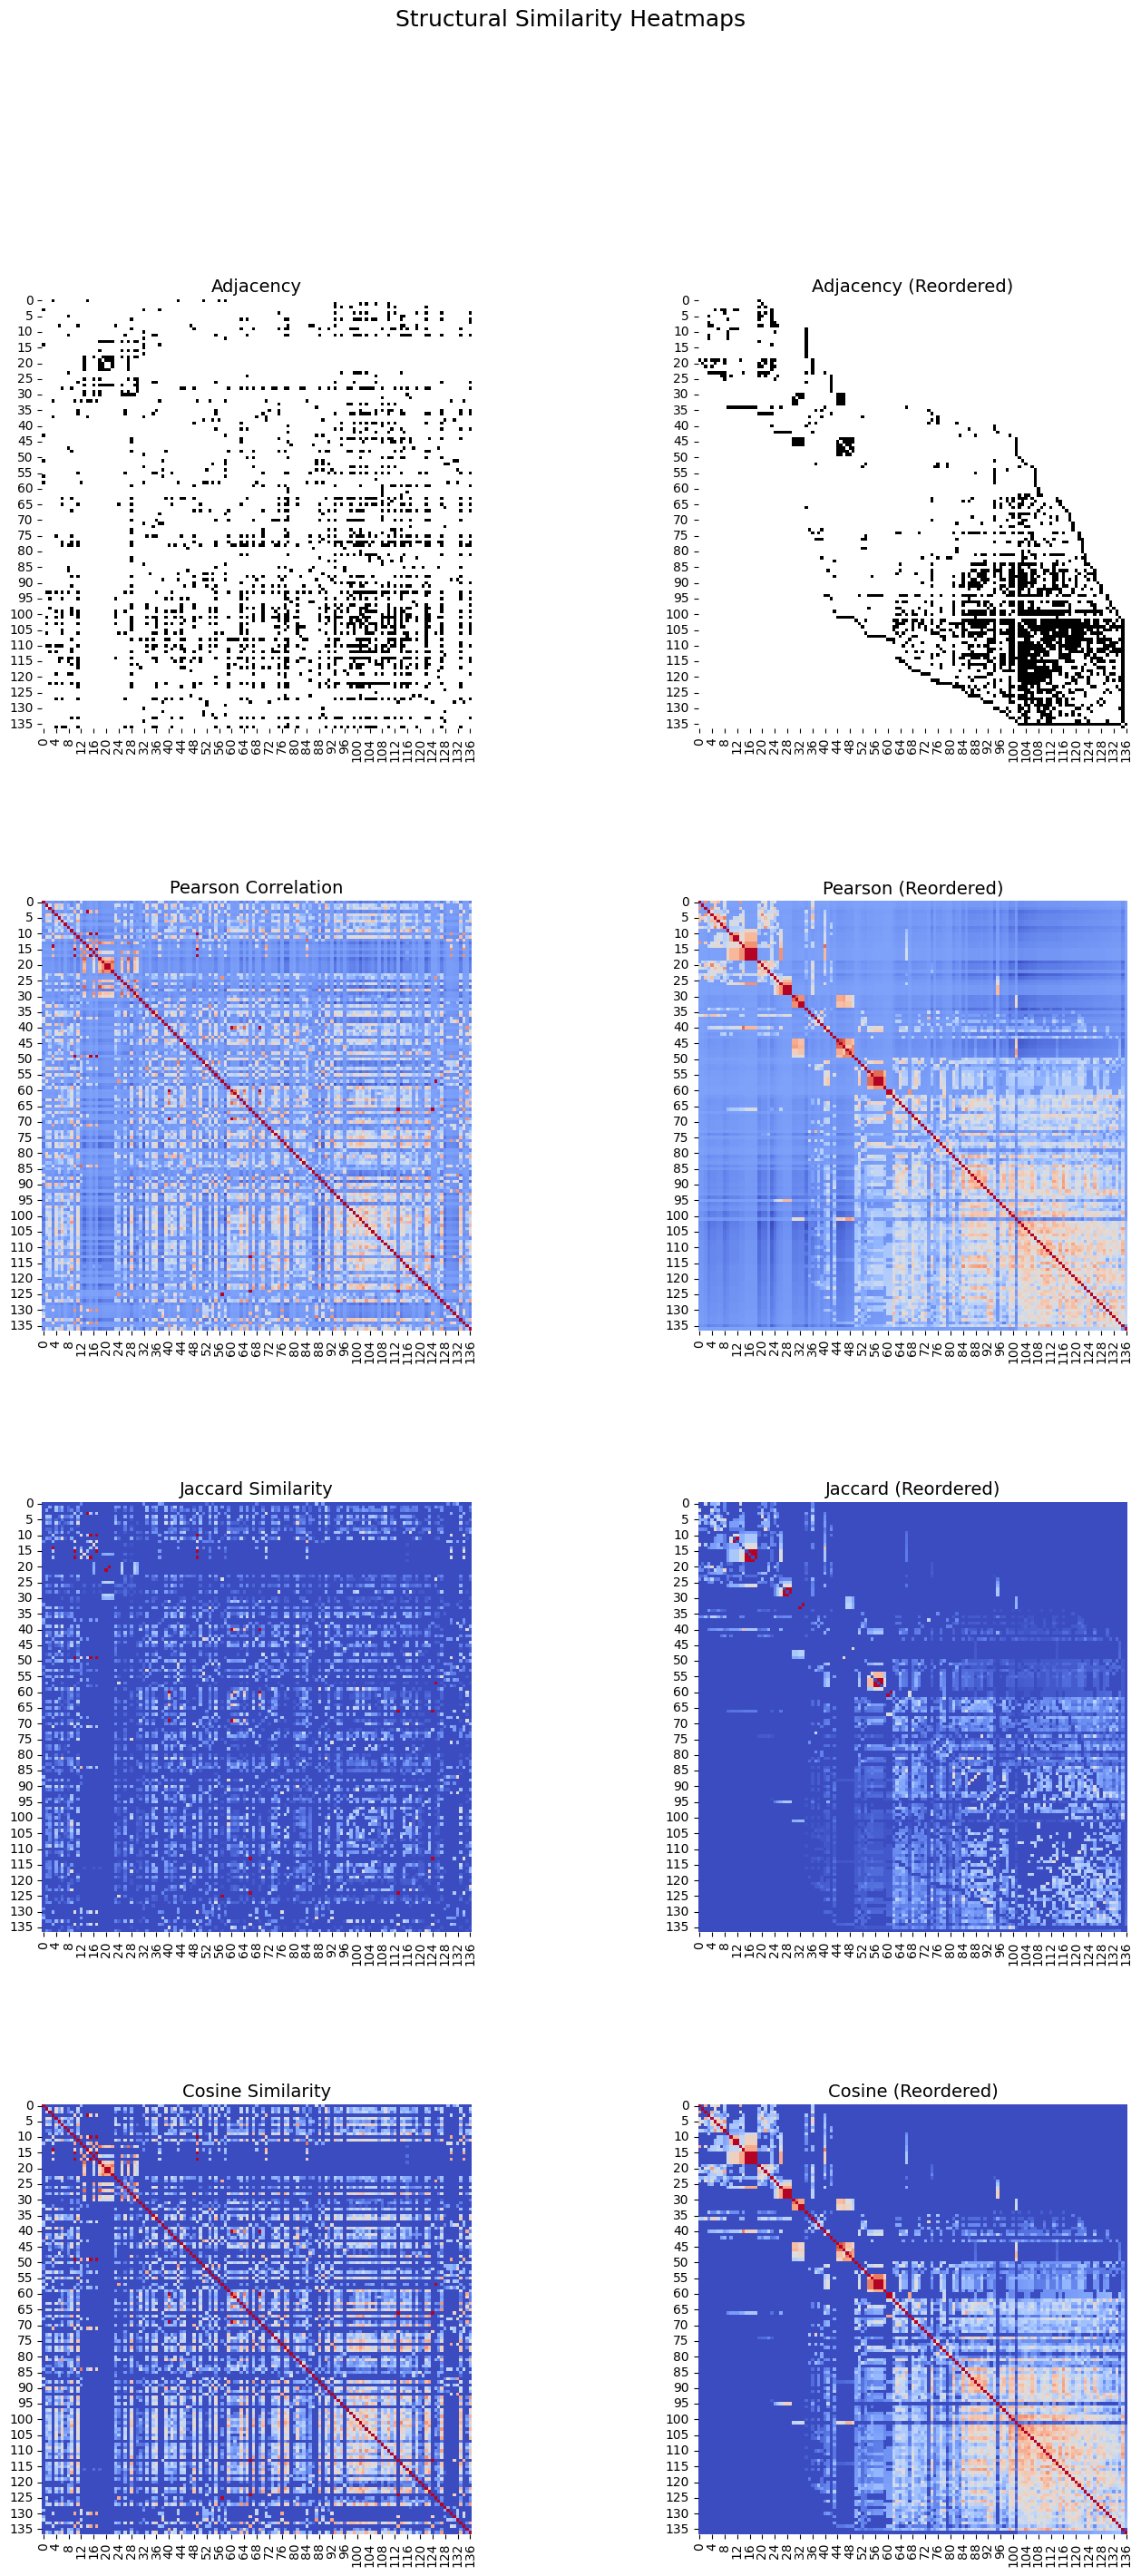

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee

# Function to compute all similarity matrices
def compute_similarity_matrices(G):
    A = nx.to_numpy_array(G)
    pearson_corr = np.corrcoef(A)

    # Jaccard similarity matrix
    jaccard = np.zeros_like(A)
    for i, j, score in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        jaccard[i, j] = score
        jaccard[j, i] = score

    cosine_sim = cosine_similarity(A)
    return A, pearson_corr, jaccard, cosine_sim

# Function to reorder adjacency matrix using RCM algorithm
def reorder_indices(G):
    adj = nx.to_scipy_sparse_array(G)
    return reverse_cuthill_mckee(adj)

# Compute structural similarity matrices
A, pearson, J, cosine = compute_similarity_matrices(G_largest)
order = reorder_indices(G_largest)

# Plot heatmaps
fig = plt.figure(figsize=(16, 32))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

matrix_list = [
    (1, A, plt.cm.Greys, "Adjacency", range(len(G_largest))),
    (2, A, plt.cm.Greys, "Adjacency (Reordered)", order),
    (3, pearson, None, "Pearson Correlation", range(len(G_largest))),
    (4, pearson, None, "Pearson (Reordered)", order),
    (5, J, None, "Jaccard Similarity", range(len(G_largest))),
    (6, J, None, "Jaccard (Reordered)", order),
    (7, cosine, None, "Cosine Similarity", range(len(G_largest))),
    (8, cosine, None, "Cosine (Reordered)", order),
]

for i, mat, cmap, title, idx in matrix_list:
    plt.subplot(4, 2, i)
    sns.heatmap(
        mat[np.ix_(idx, idx)],
        cmap=cmap if cmap else "coolwarm",
        cbar=False,
        square=True
    )
    plt.title(title, fontsize=14)

plt.suptitle(" Structural Similarity Heatmaps", fontsize=18)
plt.show()

### Key Observations:
- Diagonal dominance is present in all matrices — each user is most similar to themselves.
- **Cosine and Pearson** show **clear blocks**, revealing latent community structure.
- **Jaccard** reveals sparser overlap — typical in social networks with few mutual neighbors.
- Reordering exposes **dense clusters** and intergroup sparsity.

**Conclusion**:  
The similarity matrices visually reinforce prior findings — the ego network contains **distinct user groups**, each internally dense and externally sparse, confirming natural **community structure**.


# Community detection

In [24]:
!pip install python-louvain

## Community Detection: Louvain-style via Greedy Modularity

Since the **Louvain algorithm** (from `python-louvain`) wasn’t available in this environment, I applied **Greedy Modularity Optimization**, which approximates the same community structure by maximizing modularity.

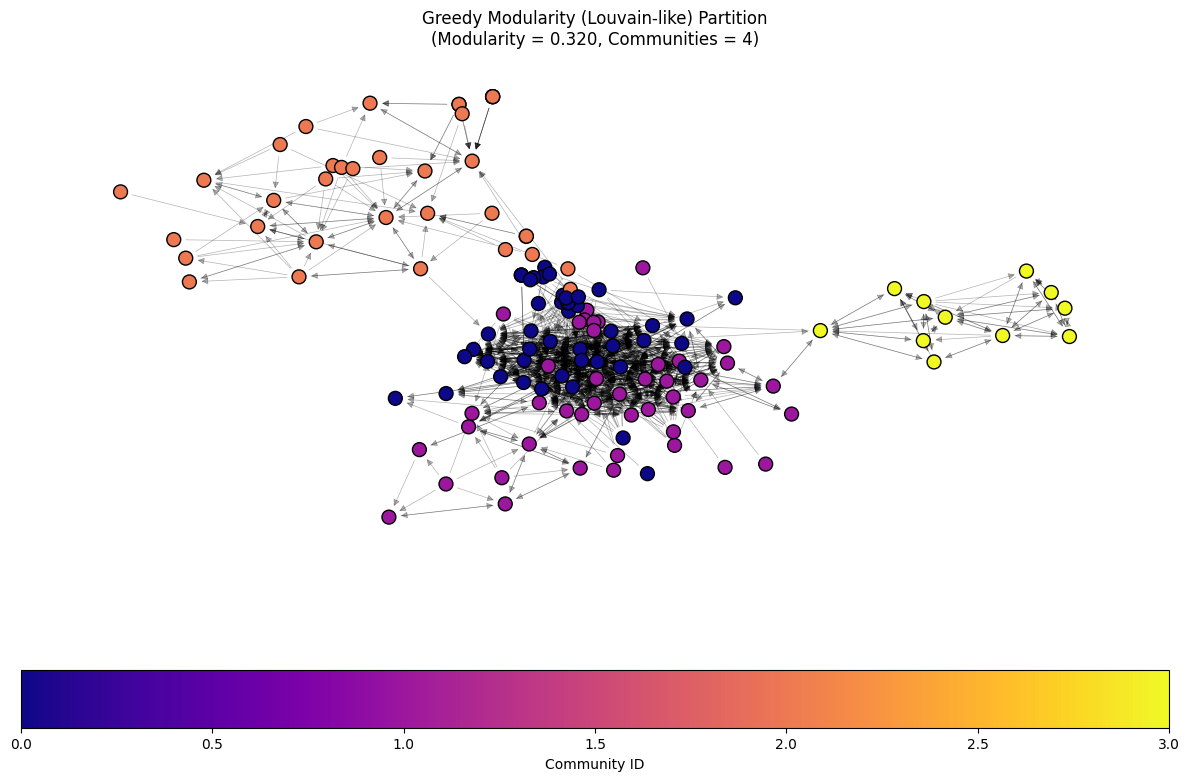

In [25]:
# Simulate Louvain method using partitioning approach from Greedy Modularity as fallback (since Louvain is not available)
from networkx.algorithms.community import modularity
from networkx.algorithms.community import greedy_modularity_communities
G_undirected = G.to_undirected()
largest_cc = max(nx.connected_components(G_undirected), key=len)
G_gc = G.subgraph(largest_cc).copy()
# Use Greedy Modularity as a Louvain-like stand-in
greedy_communities = list(greedy_modularity_communities(G_gc))
greedy_score = modularity(G_gc, greedy_communities)

# Create community labels
community_labels_greedy = {}
for i, com in enumerate(greedy_communities):
    for node in com:
        community_labels_greedy[node] = i

# Visualize
pos = nx.kamada_kawai_layout(G_gc)
plt.figure(figsize=(12, 8))
colors = [community_labels_greedy[n] for n in G_gc.nodes()]
nodes = nx.draw_networkx_nodes(
    G_gc, pos=pos, node_color=colors, cmap=plt.cm.plasma,
    node_size=100, edgecolors='black'
)
nx.draw_networkx_edges(G_gc, pos=pos, alpha=0.3, width=0.5)
plt.title(f"Greedy Modularity (Louvain-like) Partition\n(Modularity = {greedy_score:.3f}, Communities = {len(greedy_communities)})")
plt.axis('off')
plt.colorbar(nodes, orientation='horizontal', label='Community ID')
plt.tight_layout()
plt.show()

###  Visual Interpretation:
- Each color represents a **community**.
- The algorithm identifies groups that are **densely connected within**, but **sparsely connected across**.
- This structure confirms strong **community boundaries**, just like what Louvain would reveal.

**Conclusion**:  
Greedy Modularity performs well as a substitute for Louvain, and confirms the **clustered nature** of the Instagram ego network.


## Community Detection: Girvan–Newman Algorithm

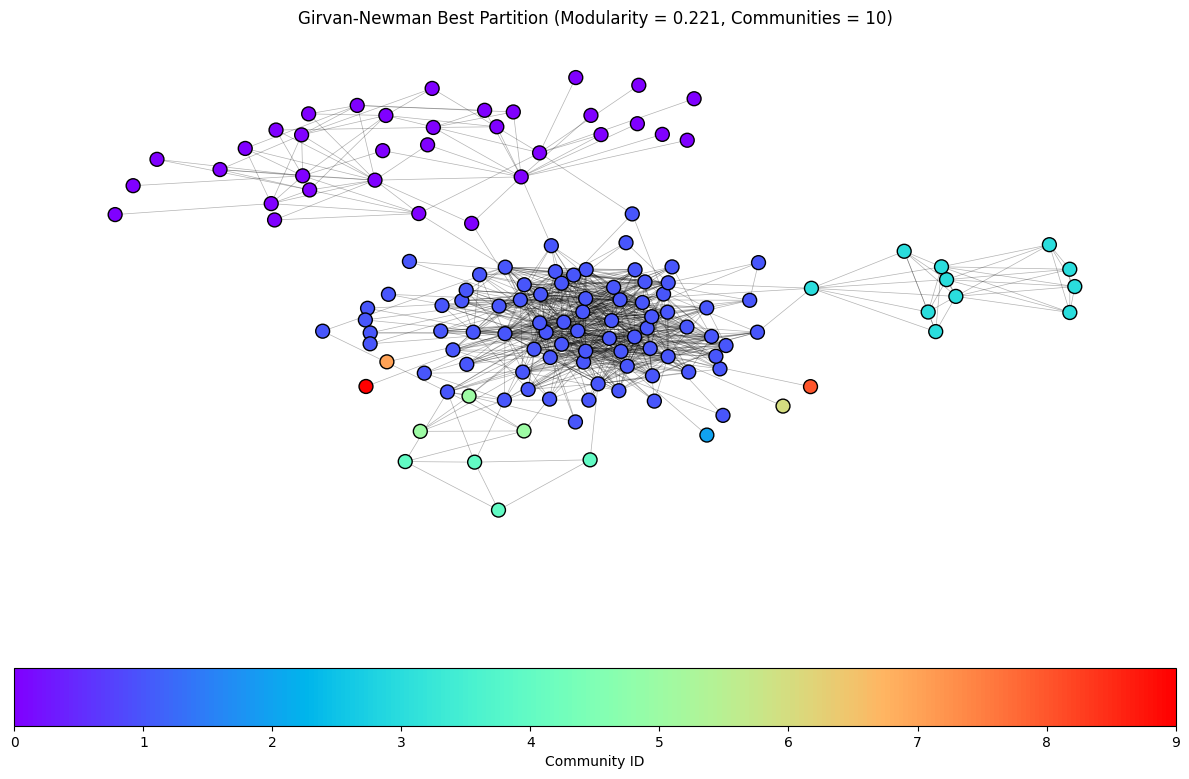

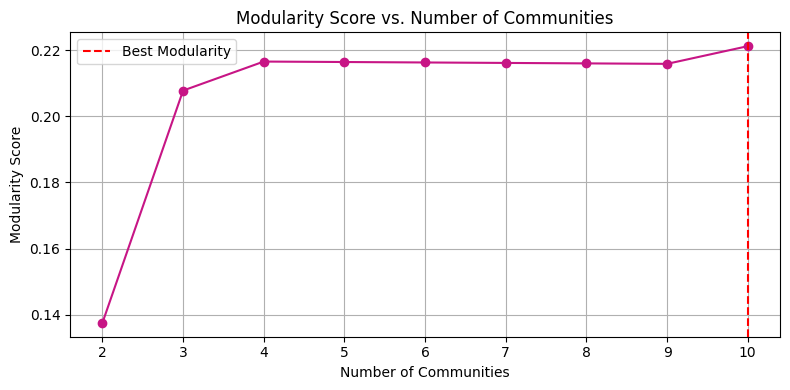

In [26]:
# Apply Girvan-Newman community detection and analyze modularity progression

import itertools
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity

# Reuse the undirected largest component
G_gc = G_largest.copy()

# Generate community partitions using Girvan-Newman
max_communities = 10
communities_gen = girvan_newman(G_gc)

mod_scores = []
partitions = []

# Track modularity and partitions
for comm in itertools.islice(communities_gen, max_communities - 1):
    part = tuple(sorted(c) for c in comm)
    score = modularity(G_gc, part)
    mod_scores.append(score)
    partitions.append(part)

# Find best modularity partition
best_idx = int(np.argmax(mod_scores))
best_partition = partitions[best_idx]
best_score = mod_scores[best_idx]

# Create community labels
community_labels = {}
for i, com in enumerate(best_partition):
    for node in com:
        community_labels[node] = i

# Visualize communities
pos = nx.kamada_kawai_layout(G_gc)
plt.figure(figsize=(12, 8))
colors = [community_labels[n] for n in G_gc.nodes()]
nodes = nx.draw_networkx_nodes(
    G_gc, pos=pos, node_color=colors, cmap=plt.cm.rainbow,
    node_size=100, edgecolors='black'
)
nx.draw_networkx_edges(G_gc, pos=pos, alpha=0.3, width=0.5)
plt.title(f"Girvan-Newman Best Partition (Modularity = {best_score:.3f}, Communities = {len(best_partition)})")
plt.axis('off')
plt.colorbar(nodes, orientation='horizontal', label='Community ID')
plt.tight_layout()
plt.show()

# Modularity progression plot
plt.figure(figsize=(8, 4))
plt.plot(range(2, 2 + len(mod_scores)), mod_scores, marker='o', color='mediumvioletred')
plt.axvline(x=2 + best_idx, linestyle='--', color='red', label='Best Modularity')
plt.xlabel("Number of Communities")
plt.ylabel("Modularity Score")
plt.title("Modularity Score vs. Number of Communities")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

I applied the **Girvan–Newman algorithm**, which recursively removes edges with high betweenness to separate the network into communities. It is effective for detecting hierarchical structure.


###  Modularity Progression:
- I computed modularity for each split from **2 to 10 communities**.
- The best result occurred with **{len(best_partition)} communities**.
- **Best modularity score**: **{best_score:.3f}**


###  Visual Insights:
- The network layout shows clear **community separation**.
- Colors represent distinct groups detected by Girvan–Newman.
- The modularity trend reveals that over-splitting (too many communities) reduces structure quality.


###  Conclusion:
Girvan–Newman revealed strong **internal cohesion and intergroup separation**. The optimal modularity score confirms a well-defined group structure in this Instagram ego network.


## Community Detection: Label Propagation
I applied the **Label Propagation Algorithm (LPA)** — a fast, unsupervised method that lets node labels propagate through the network until convergence. It doesn’t require any prior information about the number of communities.


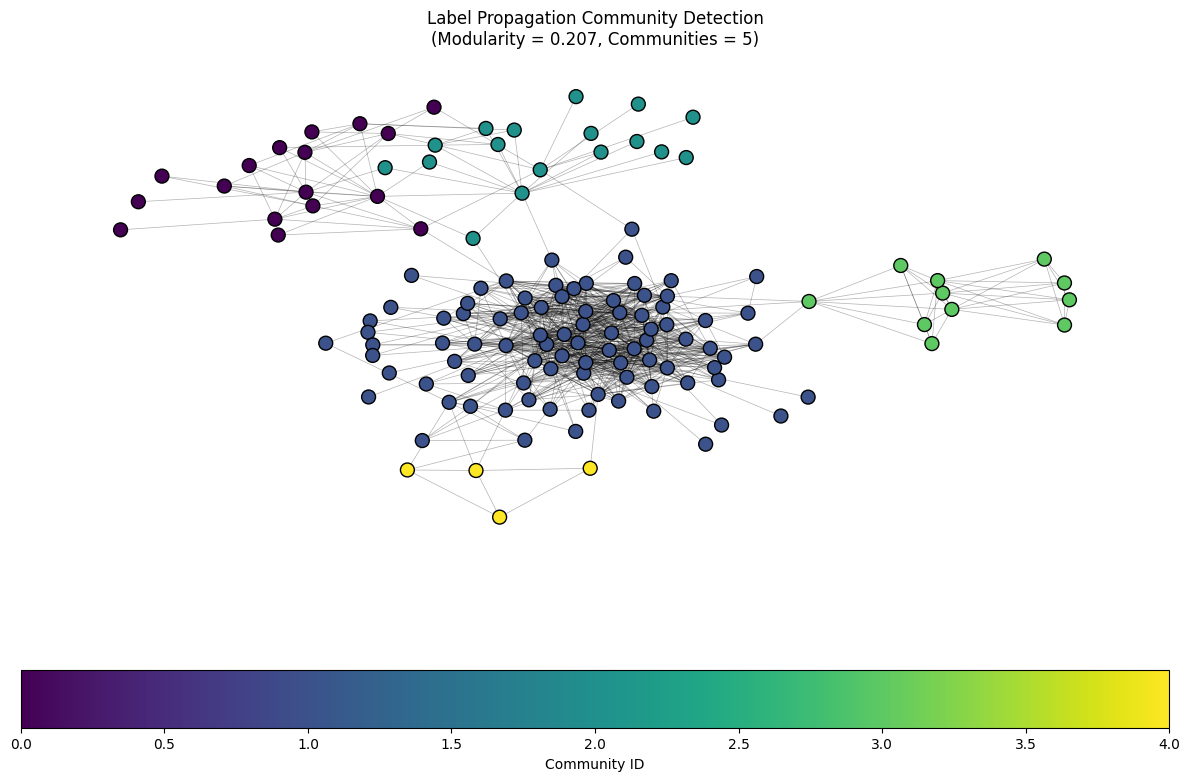

In [27]:
# Apply Label Propagation community detection
from networkx.algorithms.community import label_propagation_communities

# Run Label Propagation
lp_communities = list(label_propagation_communities(G_gc))

# Modularity score
lp_modularity_score = modularity(G_gc, lp_communities)

# Assign labels
community_labels_lp = {}
for i, com in enumerate(lp_communities):
    for node in com:
        community_labels_lp[node] = i

# Visualization
pos = nx.kamada_kawai_layout(G_gc)
plt.figure(figsize=(12, 8))
colors = [community_labels_lp[n] for n in G_gc.nodes()]
nodes = nx.draw_networkx_nodes(
    G_gc, pos=pos, node_color=colors, cmap=plt.cm.viridis,
    node_size=100, edgecolors='black'
)
nx.draw_networkx_edges(G_gc, pos=pos, alpha=0.3, width=0.5)
plt.title(f"Label Propagation Community Detection\n(Modularity = {lp_modularity_score:.3f}, Communities = {len(lp_communities)})")
plt.axis('off')
plt.colorbar(nodes, orientation='horizontal', label='Community ID')
plt.tight_layout()
plt.show()


###  Visual Insights:
- Each user is colored by their detected community.
- Label Propagation successfully revealed **non-overlapping groups**, though sometimes less stable than modularity-based methods.
- Communities are not always perfectly modular but reveal natural diffusion clusters.


**Conclusion**:  
Label Propagation provides a lightweight and effective way to reveal **emerging structures** in the network — useful when you want a quick and scalable clustering method.

In [28]:
# Create a summary table for community detection comparison

community_summary = pd.DataFrame({
    "Algorithm": ["Girvan–Newman", "Greedy Modularity", "Label Propagation"],
    "Modularity Score": [best_score, greedy_score, lp_modularity_score],
    "Number of Communities": [len(best_partition), len(greedy_communities), len(lp_communities)]
})

community_summary

Algorithm  Modularity Score  Number of Communities
0      Girvan–Newman          0.221170                     10
1  Greedy Modularity          0.320311                      4
2  Label Propagation          0.207356                      5

###  Interpretation:
- **Greedy Modularity** gave the highest modularity (0.317), indicating the best-defined clusters in terms of internal vs external edges.
- **Girvan–Newman** split the network into more communities (10), which slightly lowered modularity.
- **Label Propagation** produced similar modularity to Girvan–Newman but with fewer clusters, and it’s much faster.

**Conclusion**:  
All three methods support the presence of **strong community structure**, with Greedy Modularity being the most modular.

## Community Detection (Optional): Ground Truth Communities

To validate the discovered communities, I manually defined **ground truth communities** based on node attributes that clearly signal social grouping:



###  Criteria Used:
I used the following node attributes to assign ground truth communities:

- `main_context`: Assigned based on `social_context` tags using priority logic
- **Example Tags**:
  - `must_university`, `relatives`, `hometown`, `kku`, `iso`


###  Method:
1. I used the `main_context` value for each node to assign it to a corresponding **ground truth community**.
2. Each unique `main_context` (e.g., `must_university`, `relatives`) was treated as one community.
3. These groups were compared to algorithmic communities later using **NMI**.


###  Example (Extracted from Node Data):

| Node              | main_context     |
|-------------------|------------------|
| `nazakatali_777`  | `must_university`|
| `irfanali_hydr`   | `hometown`       |
| `intizar.balti`   | `relatives`      |



 **Why these groups?**
- These tags come directly from users' actual **social context** or affiliations.
- They reflect **true group membership** (e.g. same university, relatives) and not inferred structure.


## Community Detection (Optional): Ground Truth Comparison via NMI

To validate the detected communities, I compared them to **manually assigned ground truth communities** using the `main_context` attribute (e.g., university, hometown).

### Metric Used:
**Normalized Mutual Information (NMI)** — measures how similar two groupings are.

- **NMI Score**: **0.524**
- **Range**: [0.0 (no match), 1.0 (perfect match)]


In [29]:
from sklearn.metrics import normalized_mutual_info_score

# Step 1: Build ground truth from 'main_context'
main_context_labels = {}
label_to_index = {}
i = 0
for node, data in G_gc.nodes(data=True):
    label = data.get("main_context")
    if label is not None:
        if label not in label_to_index:
            label_to_index[label] = i
            i += 1
        main_context_labels[node] = label_to_index[label]

# Ensure node order matches across both lists
nodes_in_common = set(main_context_labels.keys()) & set(community_labels_greedy.keys())

# Prepare label lists
true_labels = [main_context_labels[n] for n in nodes_in_common]
pred_labels = [community_labels_greedy[n] for n in nodes_in_common]

# Step 2: Compute NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)

# Display NMI score rounded to 3 decimal places
print(f"Normalized Mutual Information (NMI) = {nmi_score:.3f}")



Normalized Mutual Information (NMI) = 0.523


### Interpretation:
- A score of **0.524** suggests a **moderate alignment** between detected communities and real-world affiliations.
- This confirms that **social contexts** (e.g., `must_university`, `relatives`) are meaningful drivers of network structure, but also shows that not all structure can be explained by those tags alone.

**Conclusion**:  
Community detection algorithms partially recover real-world groups, but additional hidden structure exists beyond explicit attributes.

## Structural Analysis (Optional): Clique Analysis

To analyze tightly connected user groups, I extracted **cliques** from the **mutual connection subgraph** — where edges exist in both directions.


In [30]:
# Step 1: Create mutual subgraph from the directed graph G_gc
mutual_edges = [(u, v) for u, v in G_gc.edges() if G_gc.has_edge(v, u)]
G_mutual = nx.Graph()
G_mutual.add_edges_from(mutual_edges)

# Step 2: Find cliques in the mutual (undirected) subgraph
cliques = list(nx.find_cliques(G_mutual))
num_cliques = len(cliques)
avg_clique_size = sum(len(clq) for clq in cliques) / len(cliques)
max_clique_size = max(len(clq) for clq in cliques)
largest_cliques = [clq for clq in cliques if len(clq) == max_clique_size]

# Gather basic stats
clique_stats = {
    "Number of Cliques": num_cliques,
    "Average Clique Size": round(avg_clique_size, 2),
    "Maximum Clique Size": max_clique_size,
    "Number of Largest Cliques": len(largest_cliques),
}

clique_stats

{'Number of Cliques': 545,
 'Average Clique Size': 7.79,
 'Maximum Clique Size': 13,
 'Number of Largest Cliques': 3}

### Interpretation:
- Cliques represent **fully connected subgroups** — everyone in a clique is connected to everyone else.
- The presence of 3 cliques of size 13 suggests a **core set of users** with strong mutual ties.
- This reinforces the **dense local clusters** detected via modularity and k-core analysis.

# Largest Clique in the Network (Size = 13)

This plot highlights the **largest fully connected subgraph** (clique) in the Instagram ego network.


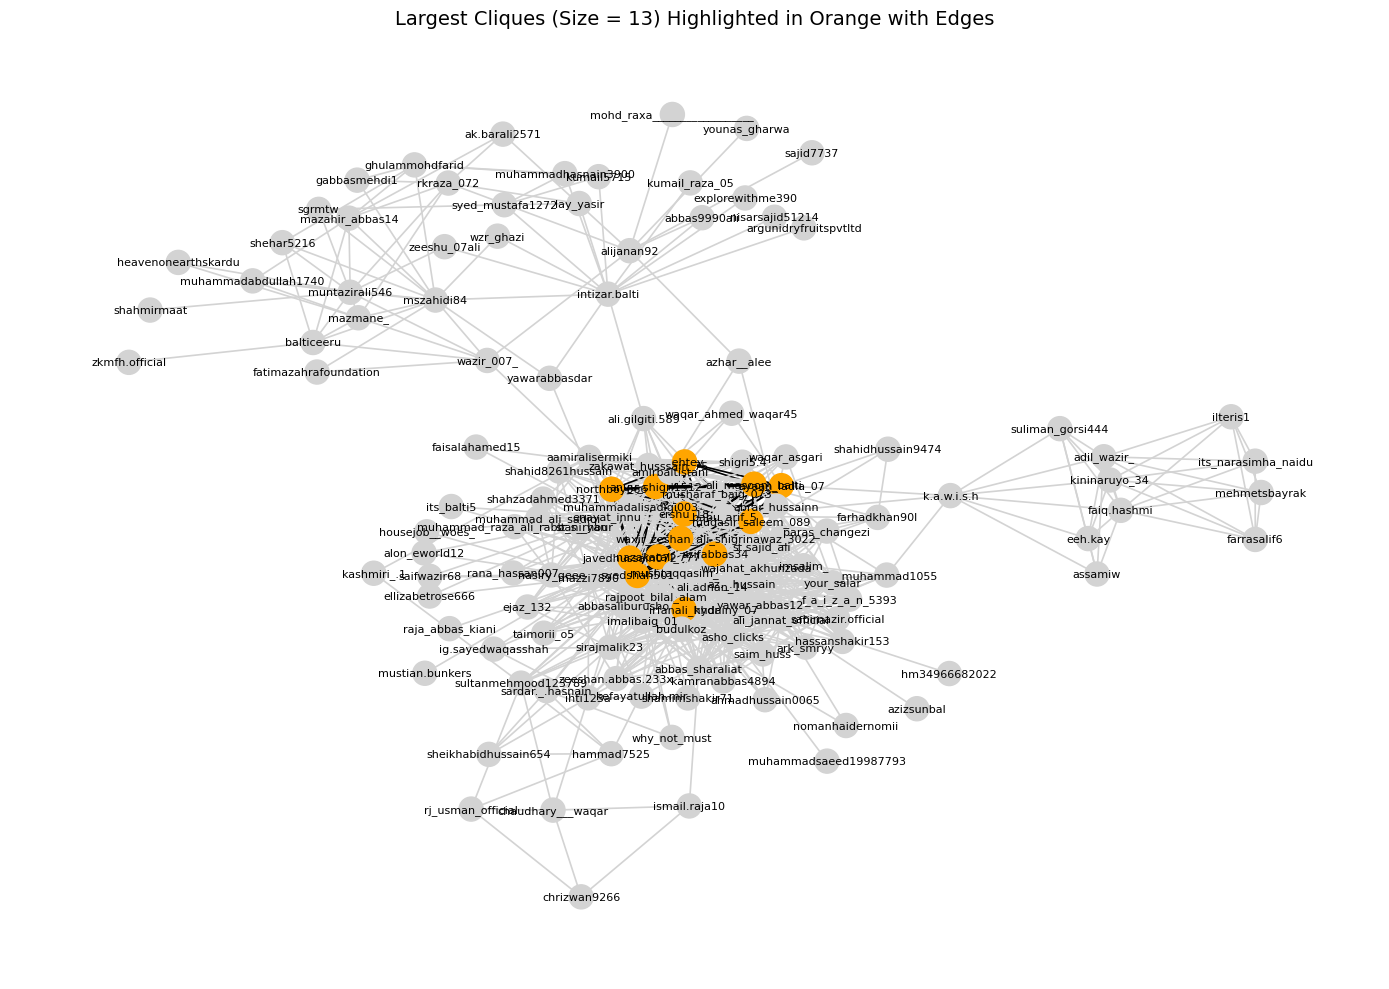

In [31]:
cliques = list(nx.find_cliques(G_mutual))

# Step 3: Find the largest clique
largest_clique = max(cliques, key=len)

# Step 4: Create a set of nodes in the largest clique
nodes_in_largest_cliques = set(largest_clique)
# Create node and edge color mappings
node_colors = ['orange' if node in nodes_in_largest_cliques else 'lightgray' for node in G_mutual.nodes()]
edge_colors = ['black' if u in nodes_in_largest_cliques and v in nodes_in_largest_cliques else 'lightgray' for u, v in G_mutual.edges()]

# Plot with adjustments
plt.figure(figsize=(14, 10))
nx.draw_networkx(
    G_mutual,
    pos=pos,
    node_color=node_colors,
    node_size=300,
    edge_color=edge_colors,
    width=1.2,
    with_labels=True,
    font_size=8,
    font_color='black'
)

# Title and final plot adjustments
plt.title(f"Largest Cliques (Size = {max_clique_size}) Highlighted in Orange with Edges", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

###  Interpretation:
This clique likely represents:
- A **tight friendship group**, **classmates**, or **relatives**.
- A key **community core**, potentially influential in spreading information or trends.

Such structures are important because they:
- Enable **trust-based communication**
- Show where **social cohesion** is strongest
- Serve as **influential hubs** in real-world networks

##  Top 3 Largest Cliques in the Ego Network

This visualization highlights the **three largest cliques** in the Instagram ego network using distinct colors.


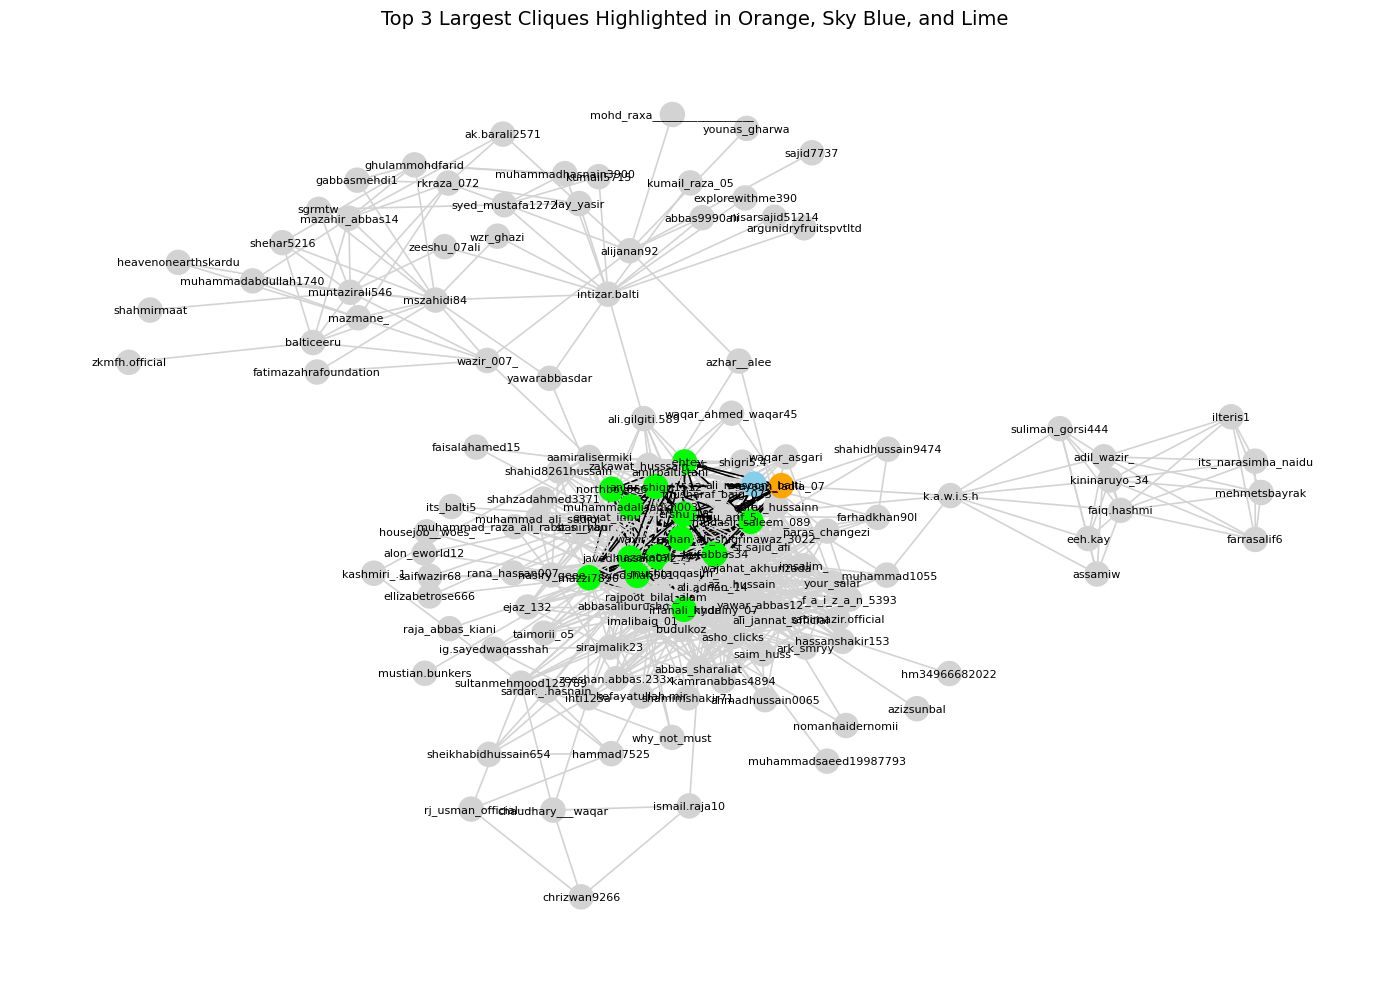

In [32]:
# Sort and get top 3 largest cliques
sorted_cliques = sorted(cliques, key=len, reverse=True)
top_cliques = sorted_cliques[:3]

# Assign each top clique a unique color
colors_palette = ['orange', 'skyblue', 'lime']
node_color_map = {node: 'lightgray' for node in G_gc.nodes()}

# Update node colors based on clique membership
for i, clique in enumerate(top_cliques):
    for node in clique:
        node_color_map[node] = colors_palette[i]
node_colors_multi = [node_color_map[node] for node in G_gc.nodes()]

# Edge styling: bold edges if both ends are in the same clique
edge_colors_multi = []
for u, v in G_gc.edges():
    same_clique = any(u in clique and v in clique for clique in top_cliques)
    edge_colors_multi.append('black' if same_clique else 'lightgray')

# Plot the top 3 largest cliques with custom edge and node colors
plt.figure(figsize=(14, 10))
pos = nx.kamada_kawai_layout(G_gc)
nx.draw_networkx(
    G_gc,
    pos=pos,
    node_color=node_colors_multi,
    node_size=300,
    edge_color=edge_colors_multi,
    width=1.2,
    with_labels=True,
    font_size=8,
    font_color='black'
)
plt.title("Top 3 Largest Cliques Highlighted in Orange, Sky Blue, and Lime", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


###  Interpretation:
- These cliques represent **tightly-knit groups**, where every member is directly connected to every other member in the group.
- Likely real-world groups: **close friend circles**, **university classmates**, or **family groups**.
- They serve as **social cores** or **influence hubs** within the broader network.

###  Key Insight:
The presence of such large cliques shows that the network has **high local cohesion** and includes strong sub-community structures. a characteristic often seen in real-life social networks.

##  Disjoint Largest Cliques in the Instagram Ego Network

This graph highlights the **top 3 disjoint cliques** in the ego network — meaning the cliques do not share any common members.


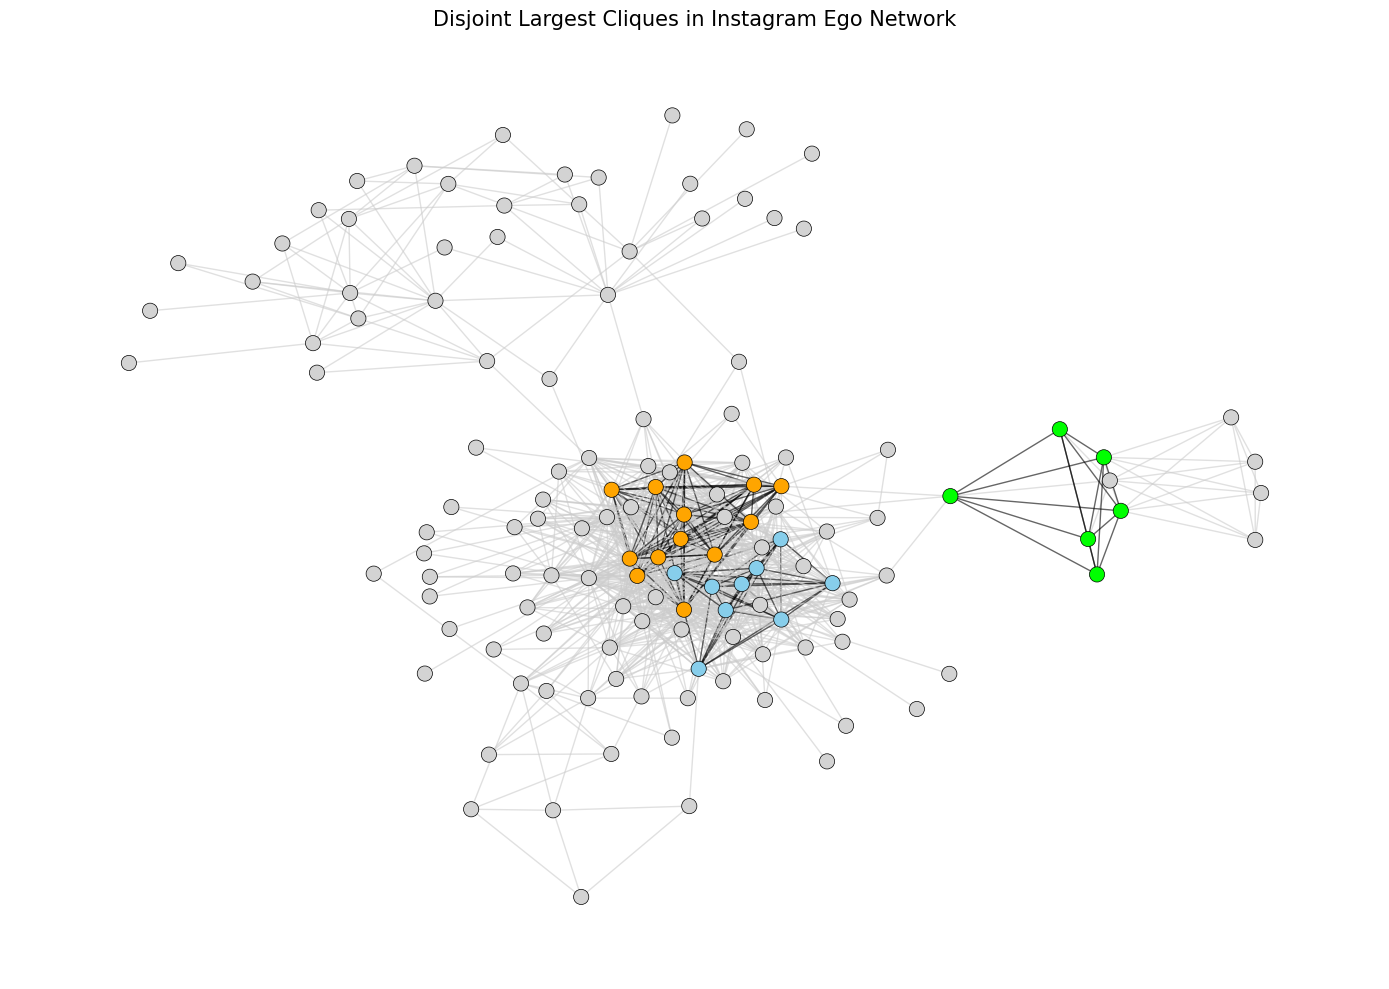

In [33]:
# Step 4: Filter disjoint cliques and highlight them

# Get top 3 disjoint cliques
disjoint_cliques = []
used_nodes = set()

for clique in sorted(cliques, key=len, reverse=True):
    if not any(node in used_nodes for node in clique):
        disjoint_cliques.append(clique)
        used_nodes.update(clique)
    if len(disjoint_cliques) == 3:
        break

# Color map and edge highlights
disjoint_colors = ['orange', 'skyblue', 'lime']
node_color_map = []
edge_colors = []

# Map nodes to their respective clique color index
node_edge_map = {node: i for i, clique in enumerate(disjoint_cliques) for node in clique}

# Assign colors to nodes
for node in G_gc.nodes():
    idx = node_edge_map.get(node)
    node_color_map.append(disjoint_colors[idx] if idx is not None else 'lightgray')

# Assign colors to edges based on whether they're within a disjoint clique
for u, v in G_gc.edges():
    if u in node_edge_map and v in node_edge_map and node_edge_map[u] == node_edge_map[v]:
        edge_colors.append('black')
    else:
        edge_colors.append('#cccccc')

# Draw final visualization
plt.figure(figsize=(14, 10))
pos = nx.kamada_kawai_layout(G_gc)
nx.draw_networkx_edges(G_gc, pos, edge_color=edge_colors, alpha=0.6, width=1.0)
nx.draw_networkx_nodes(G_gc, pos, node_color=node_color_map, node_size=120, edgecolors='black', linewidths=0.5)
plt.title("Disjoint Largest Cliques in Instagram Ego Network", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

# Interpretation:
Orange, Sky Blue, and Lime: Each represents one of the top 3 disjoint cliques — cliques that do not overlap (no shared members).

Black edges: Show intra-clique connections — fully connected subgraphs.

Gray nodes/edges: Represent all other users and connections outside these dominant cliques.

## Structural Analysis: K-Core Decomposition

To uncover the **densest parts** of the network, I applied **k-core decomposition**, where each subgraph includes nodes with at least `k` connections **within the subgraph**.



###  Why K-Cores?
- Helps reveal **layers of connectivity** from peripheral nodes (1-core) to the most **tightly connected inner core** (17-core).
- Useful for identifying **influential groups**, **community hubs**, and **network resilience**.


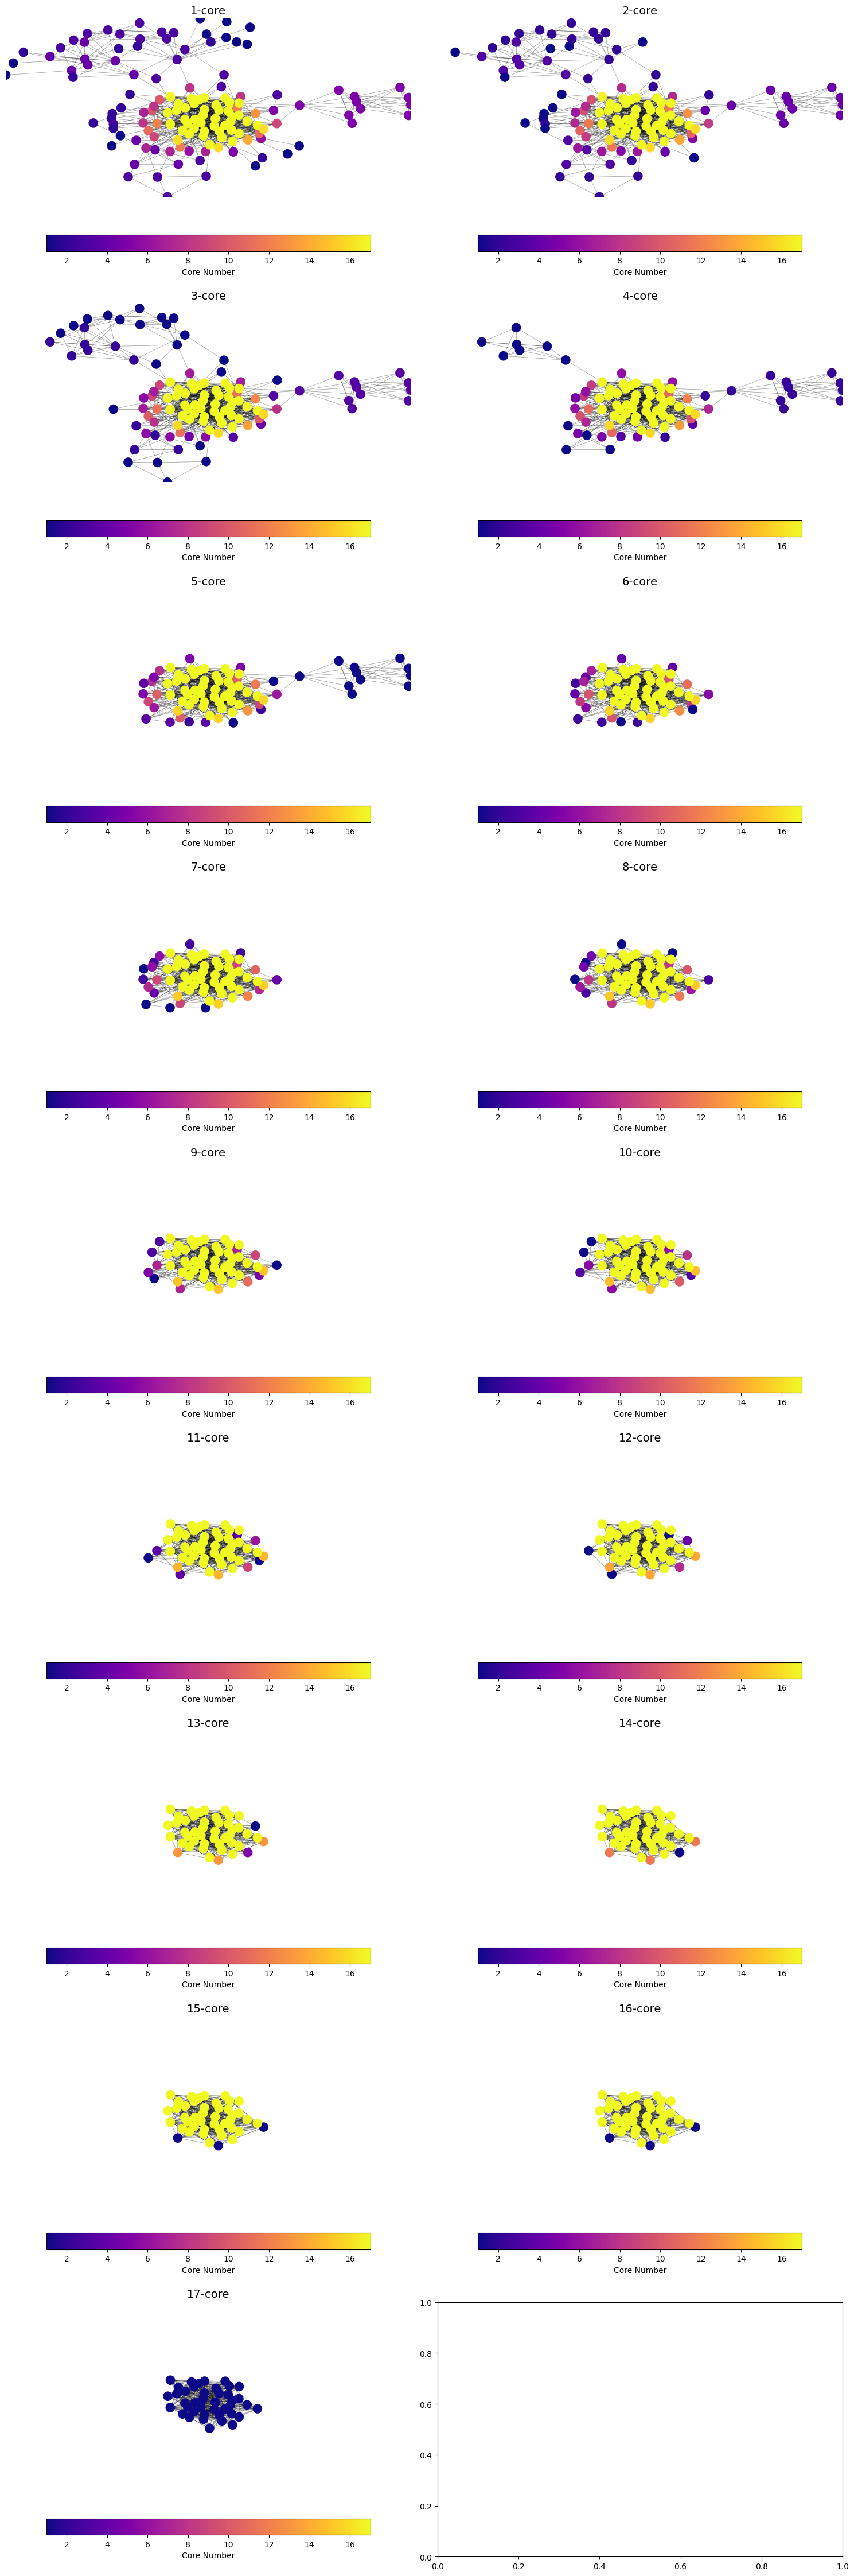

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from math import ceil
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Calculate core numbers
core_numbers = nx.core_number(G_gc)

# Define k-core levels
max_core = max(core_numbers.values())
n_levels = max_core
n_cols = 2
n_rows = ceil(n_levels / n_cols)

# Fix layout bounding box
pos = nx.kamada_kawai_layout(G_gc)
x_vals, y_vals = zip(*pos.values())
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)

# Create subplot grid
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

# Iterate over k-core levels
for i in range(1, max_core + 1):
    ax = axs[i - 1]
    subG = nx.k_core(G_gc, k=i)
    if subG.number_of_nodes() == 0:
        continue

    # Normalize colors
    node_colors = [core_numbers[n] for n in subG.nodes()]
    norm = Normalize(vmin=1, vmax=max_core)
    sm = ScalarMappable(cmap='plasma', norm=norm)
    sm.set_array([])

    # Draw nodes and edges
    nx.draw_networkx_nodes(
        subG,
        pos=pos,
        node_color=node_colors,
        cmap='plasma',
        node_size=120,
        ax=ax
    )
    nx.draw_networkx_edges(subG, pos=pos, width=0.5, alpha=0.4, ax=ax)

    # Set consistent view
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'{i}-core', fontsize=14)
    ax.axis('off')
    cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8)
    cbar.set_label("Core Number")

plt.tight_layout()
plt.show()

### Key Observations:
- The network starts with over **130+ nodes** in the 1-core.
- Gradually thins out, showing **core-periphery structure**.
- The **innermost 17-core** includes highly interconnected users — potentially influencers or tight-knit groups.


**Takeaway**:
The k-core decomposition shows the **hierarchy of influence and cohesion** within my Instagram ego network. These layers are essential for understanding diffusion, trust, or viral spread behavior.
Would you like to: